In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic
from scipy.optimize import minimize

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### MCMC
# import emcee
# import time
# import mcmc as mc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [3]:
################
### LMC Data ###
################

### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

gcs = fits.getdata('allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = gcs[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### PARSEC
parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

### GC cluster tables
'''
The ACS survey of Galactic globular clusters – XIV. Bayesian single-population analysis of 69 globular clusters
Wagner-Kaiser et al. 2017
'''
import pandas as pd
supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp3 = pd.read_csv('../stx544_Supp/Table3.txt',comment='#',
                    names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',
                           'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',
                           'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',
                           'RelativeAge'],sep='\s+')

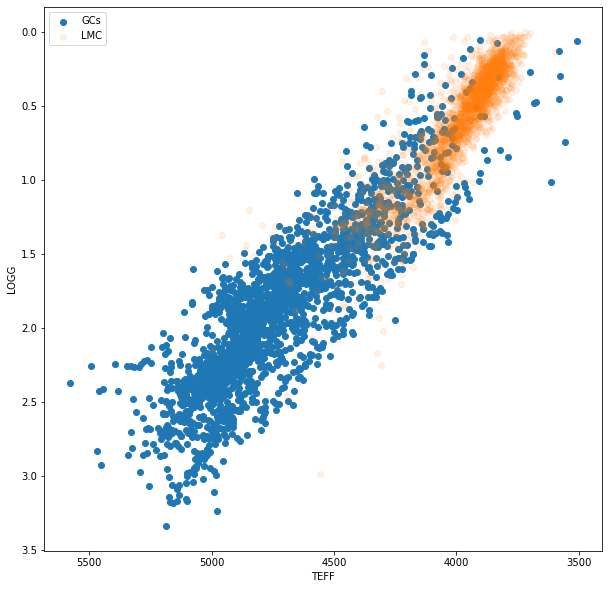

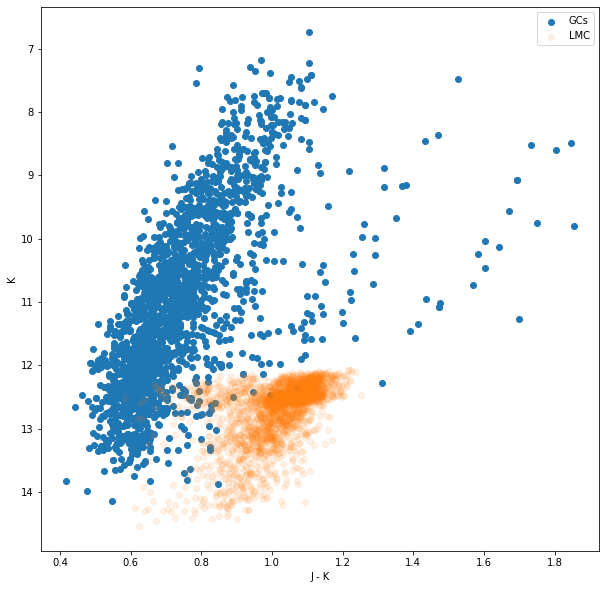

In [4]:
plt.figure(figsize=[10,10])
plt.scatter(gcs['TEFF'],gcs['LOGG'],label='GCs')
plt.scatter(lmc['TEFF'],lmc['LOGG'],label='LMC',alpha=0.1)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.legend()
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(gcs['J']-gcs['K'],gcs['K'],label='GCs')
plt.scatter(lmc['J']-lmc['K'],lmc['K'],label='LMC',alpha=0.1)

plt.gca().invert_yaxis()

plt.legend()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()

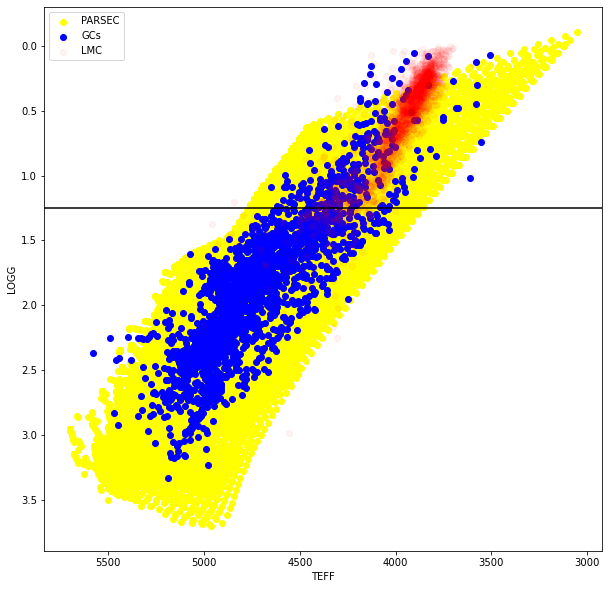

In [5]:
plt.figure(figsize=[10,10])
plt.scatter(10**parsec['logTe'],parsec['logg'],label='PARSEC',c='yellow')
plt.scatter(gcs['TEFF'],gcs['LOGG'],label='GCs',c='b')
plt.scatter(lmc['TEFF'],lmc['LOGG'],label='LMC',alpha=0.05,c='r')

plt.axhline(1.25,c='k')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.legend()
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')
plt.savefig('hr_parsec_lmc_gcs.pdf',bbox_inches='tight')
plt.show()

In [6]:
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

_,_, ldist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])

lmc_ksmag = absmag(lmc['K'],ldist)
gcs_ksmag = absmag(gcs['K'],gcs['distmed'])

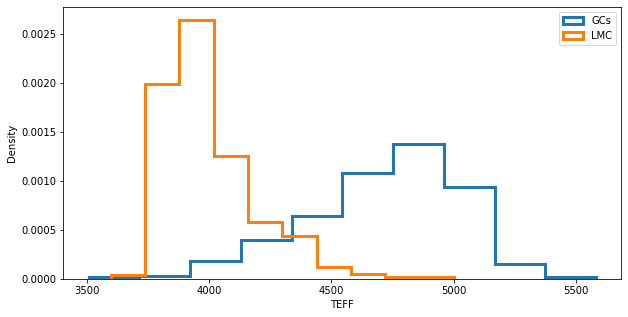

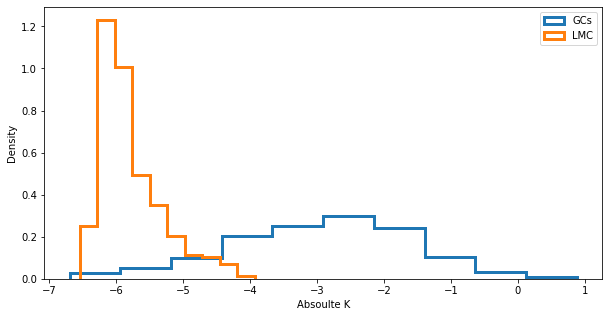

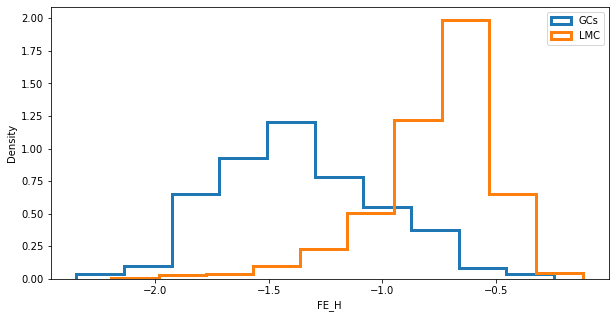

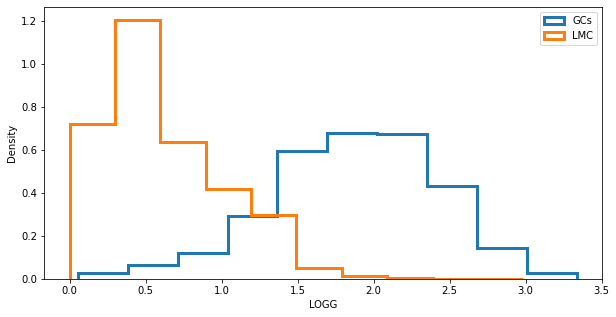

In [7]:
### TEFF
plt.figure(figsize=[10,5])
plt.hist(gcs['TEFF'],density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(lmc['TEFF'],density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.xlabel(r'TEFF')
plt.ylabel(r'Density')
plt.savefig('Teff_hist.pdf',bbox_inches='tight')
plt.show()

### K
plt.figure(figsize=[10,5])
plt.hist(gcs_ksmag,density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(lmc_ksmag,density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.xlabel(r'Absoulte K')
plt.ylabel(r'Density')
plt.savefig('K_hist.pdf',bbox_inches='tight')
plt.show()

### FE_H
plt.figure(figsize=[10,5])
plt.hist(gcs['FE_H'],density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(lmc['FE_H'],density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.xlabel(r'FE_H')
plt.ylabel(r'Density')
plt.savefig('feh_hist.pdf',bbox_inches='tight')
plt.show()

### LOGG
plt.figure(figsize=[10,5])
plt.hist(gcs['LOGG'],density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(lmc['LOGG'],density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.xlabel(r'LOGG')
plt.ylabel(r'Density')
plt.savefig('logg_hist.pdf',bbox_inches='tight')
plt.show()

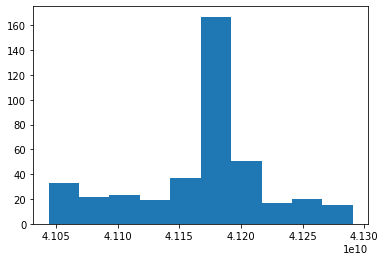

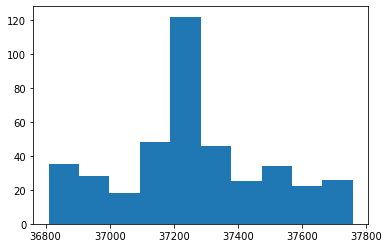

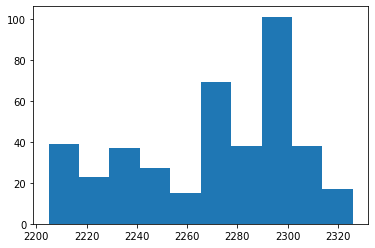

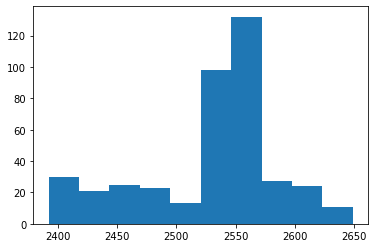

In [8]:
plt.hist(np.correlate(gcs['TEFF'],lmc['TEFF']))
plt.show()

plt.hist(np.correlate(gcs_ksmag,lmc_ksmag))
plt.show()

plt.hist(np.correlate(gcs['FE_H'],lmc['FE_H']))
plt.show()

plt.hist(np.correlate(gcs['LOGG'],lmc['LOGG']))
plt.show()

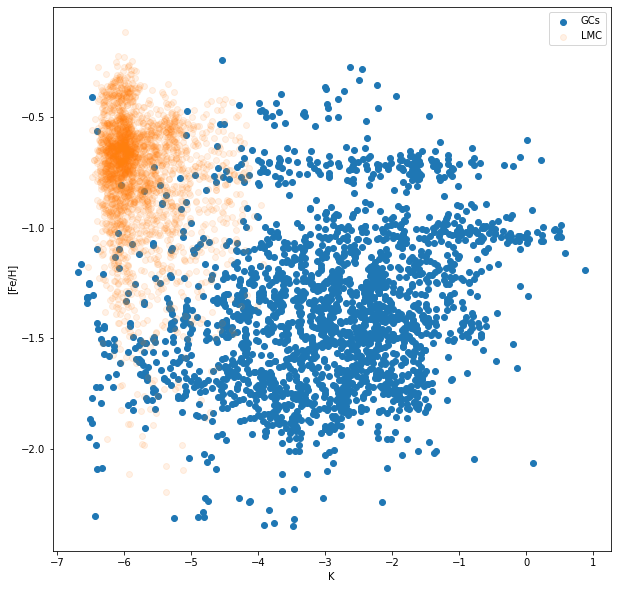

In [9]:
plt.figure(figsize=[10,10])
plt.scatter(gcs_ksmag,gcs['FE_H'],label='GCs')
plt.scatter(lmc_ksmag,lmc['FE_H'],alpha=0.1,label='LMC')

# plt.title(r'L-Z')
plt.xlabel(r'K')
plt.ylabel(r'[Fe/H]')
plt.legend()
plt.savefig('gcs_lmc_feh_k.pdf',bbox_inches='tight')

plt.show()

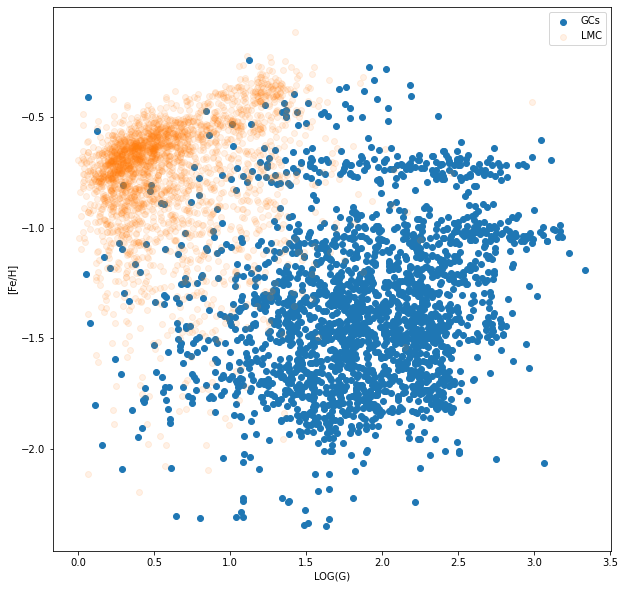

In [10]:
plt.figure(figsize=[10,10])
plt.scatter(gcs['LOGG'],gcs['FE_H'],label='GCs')
plt.scatter(lmc['LOGG'],lmc['FE_H'],alpha=0.1,label='LMC')
plt.legend()

plt.xlabel(r'LOG(G)')
plt.ylabel(r'[Fe/H]')
plt.savefig('gcs_lmc_feh_logg.pdf',bbox_inches='tight')

plt.show()

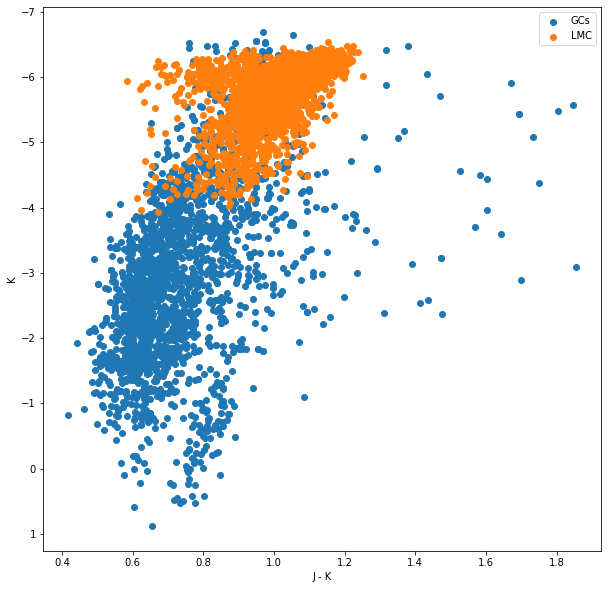

In [11]:
plt.figure(figsize=[10,10])
plt.scatter(gcs['J']-gcs['K'],gcs_ksmag,label='GCs')
plt.scatter(lmc['J']-lmc['K'],lmc_ksmag,label='LMC',alpha=1)

plt.gca().invert_yaxis()

plt.legend()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()

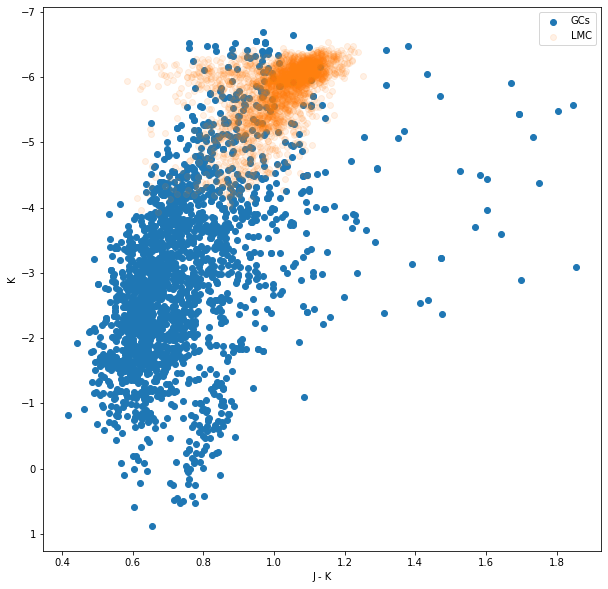

In [12]:
over_phot_idx = np.where((gcs_ksmag>=min(lmc_ksmag))&((gcs_ksmag<=max(lmc_ksmag)))
                         &(gcs['J']-gcs['K']>=min(lmc['J']-lmc['K']))&(gcs['J']-gcs['K']<=max(lmc['J']-lmc['K'])))

plt.figure(figsize=[10,10])
plt.scatter(gcs['J']-gcs['K'],gcs_ksmag,label='GCs')
plt.scatter(lmc['J']-lmc['K'],lmc_ksmag,label='LMC',alpha=0.1)
# plt.scatter((gcs['J']-gcs['K'])[over_phot_idx],gcs_ksmag[over_phot_idx],label='Overlap')

plt.gca().invert_yaxis()

plt.legend()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.savefig('gcs_lmc_cmd.pdf',bbox_inches='tight')
plt.show()

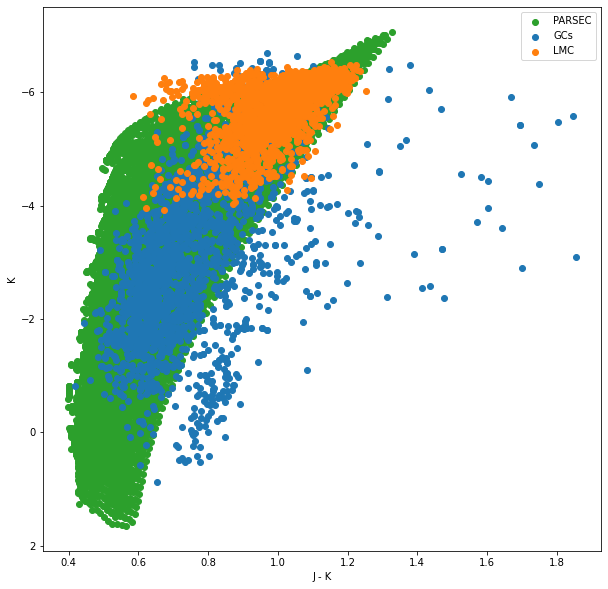

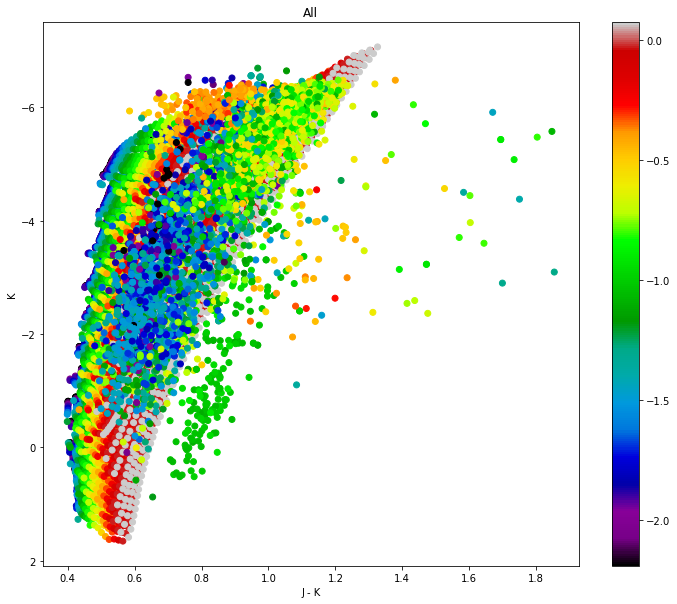

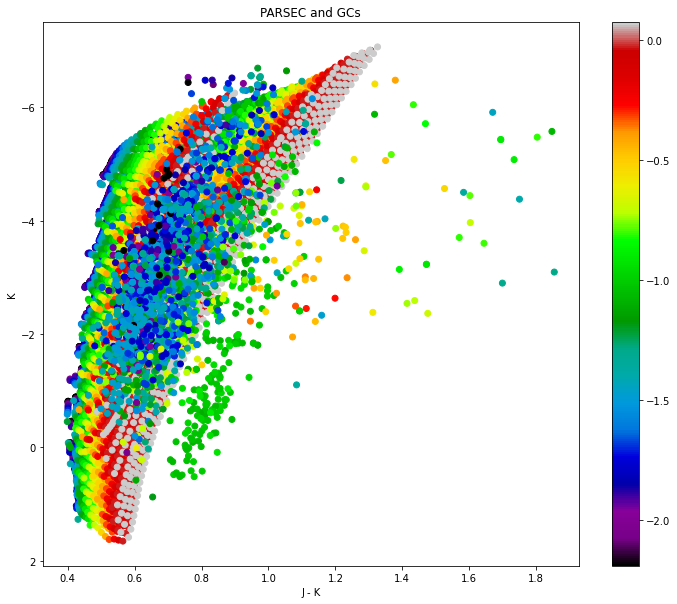

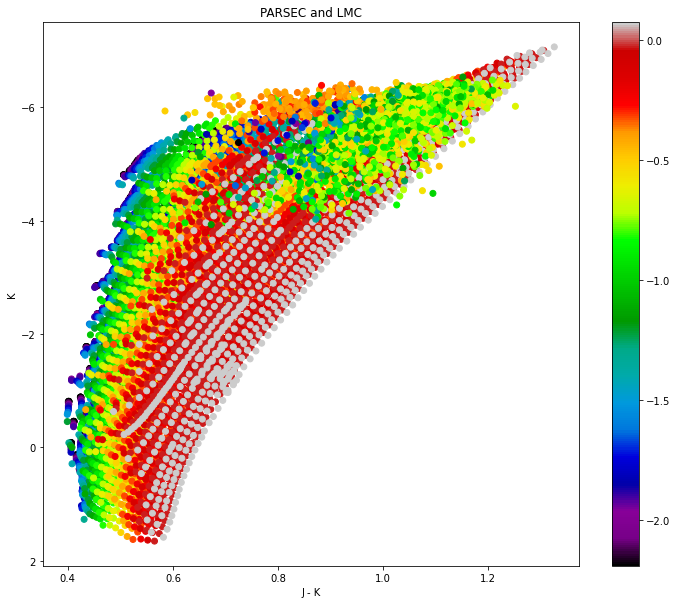

In [13]:
plt.figure(figsize=[10,10])
plt.scatter(parsec['Jmag']-parsec['Ksmag'],parsec['Ksmag'],label='PARSEC',c='tab:green')
plt.scatter(gcs['J']-gcs['K'],gcs_ksmag,label='GCs',c='tab:blue')
plt.scatter(lmc['J']-lmc['K'],lmc_ksmag,label='LMC',alpha=1,c='tab:orange')

plt.gca().invert_yaxis()

plt.legend()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.savefig('gcs_lmc_parsec_overlap.pdf',bbox_inches='tight')
plt.show()

####
plt.figure(figsize=[12,10])
plt.scatter(parsec['Jmag']-parsec['Ksmag'],parsec['Ksmag'],c=parsec['MH'],vmax=max(parsec['MH']),
            vmin=min(parsec['MH']),cmap='nipy_spectral')
plt.scatter(gcs['J']-gcs['K'],gcs_ksmag,label='GCs',c=gcs['FE_H'],vmax=max(parsec['MH']),vmin=min(parsec['MH']),
            cmap='nipy_spectral')
plt.scatter(lmc['J']-lmc['K'],lmc_ksmag,label='LMC',c=lmc['FE_H'],vmax=max(parsec['MH']),vmin=min(parsec['MH']),
            cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'All')
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.savefig('gcs_lmc_parsec_overlap_feh.pdf',bbox_inches='tight')
plt.show()

####
plt.figure(figsize=[12,10])
plt.scatter(parsec['Jmag']-parsec['Ksmag'],parsec['Ksmag'],c=parsec['MH'],vmax=max(parsec['MH']),
            vmin=min(parsec['MH']),cmap='nipy_spectral')
plt.scatter(gcs['J']-gcs['K'],gcs_ksmag,label='GCs',c=gcs['FE_H'],vmax=max(parsec['MH']),vmin=min(parsec['MH']),
            cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title('PARSEC and GCs')
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.savefig('gcs_parsec_overlap_feh.pdf',bbox_inches='tight')
plt.show()

###
plt.figure(figsize=[12,10])
plt.scatter(parsec['Jmag']-parsec['Ksmag'],parsec['Ksmag'],c=parsec['MH'],vmax=max(parsec['MH']),
            vmin=min(parsec['MH']),cmap='nipy_spectral')
plt.scatter(lmc['J']-lmc['K'],lmc_ksmag,label='LMC',c=lmc['FE_H'],vmax=max(parsec['MH']),vmin=min(parsec['MH']),
            cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'PARSEC and LMC')
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.savefig('lmc_parsec_overlap_feh.pdf',bbox_inches='tight')
plt.show()

In [14]:
pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

gcs_arr = np.array([np.log10(gcs['TEFF']),gcs_ksmag,gcs['FE_H'],gcs['logg']]).T
lmc_arr = np.array([np.log10(lmc['TEFF']),lmc_ksmag,lmc['FE_H'],lmc['logg']]).T

new_gcs = pca_transform.transform(gcs_arr)
new_lmc = pca_transform.transform(lmc_arr)
new_par = pca_transform.transform(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

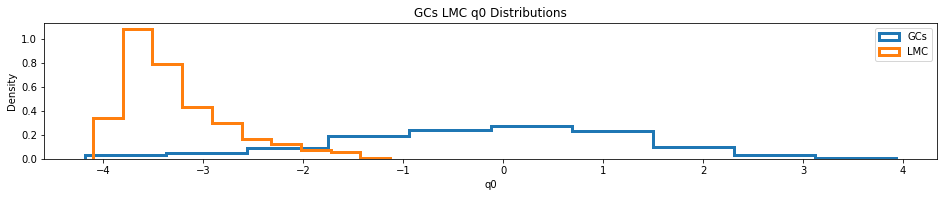

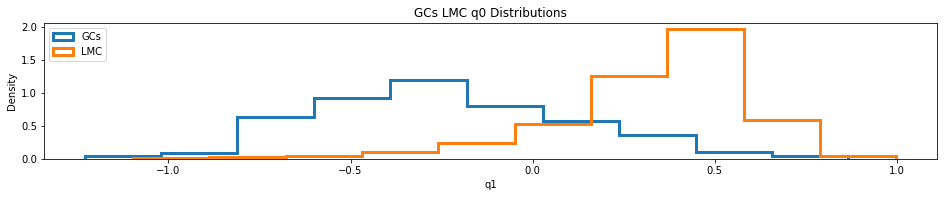

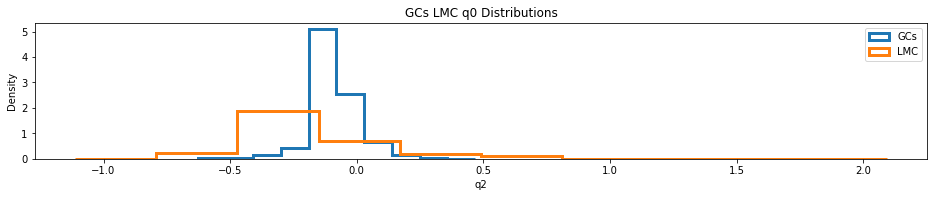

In [15]:
### q0
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[0],density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[0],density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0 Distributions')
plt.xlabel(r'q0')
plt.ylabel(r'Density')
plt.show()

### q1
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[1],density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[1],density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0 Distributions')
plt.xlabel(r'q1')
plt.ylabel(r'Density')
plt.show()

### q2
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[2],density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[2],density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0 Distributions')
plt.xlabel(r'q2')
plt.ylabel(r'Density')
plt.show()

In [16]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages'

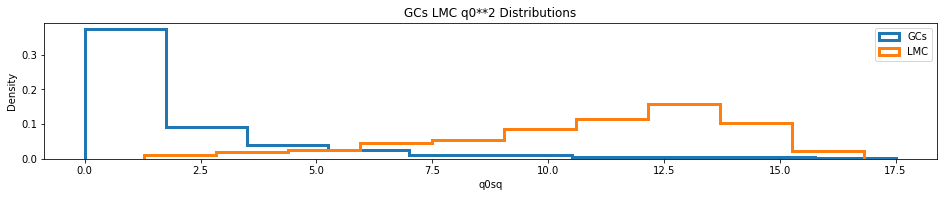

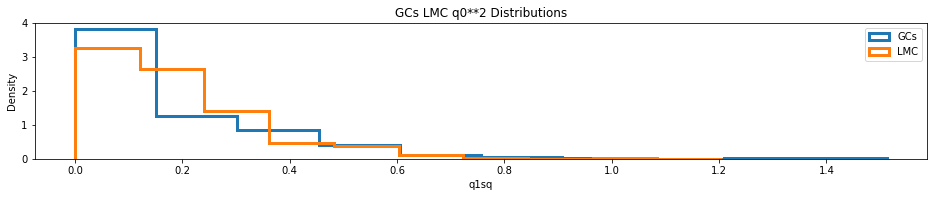

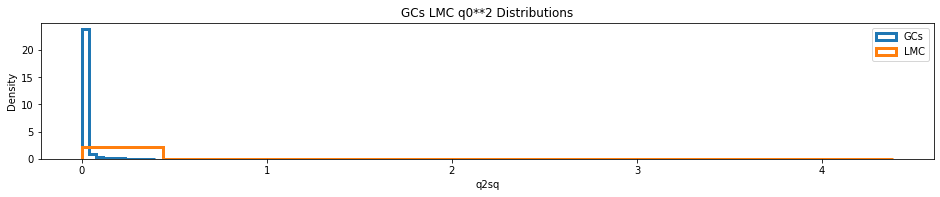

In [17]:
### q0sq
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[0]**2,density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[0]**2,density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0**2 Distributions')
plt.xlabel(r'q0sq')
plt.ylabel(r'Density')
plt.show()

### q1sq
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[1]**2,density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[1]**2,density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0**2 Distributions')
plt.xlabel(r'q1sq')
plt.ylabel(r'Density')
plt.show()

### q2sq
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[2]**2,density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[2]**2,density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0**2 Distributions')
plt.xlabel(r'q2sq')
plt.ylabel(r'Density')
plt.show()

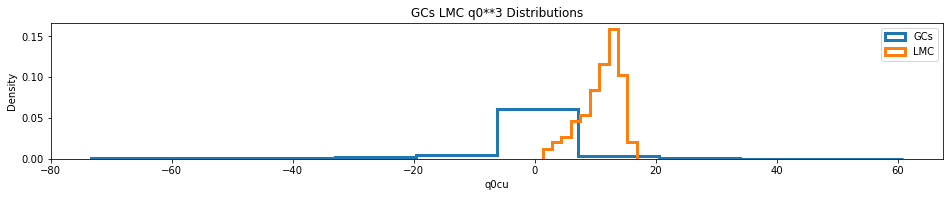

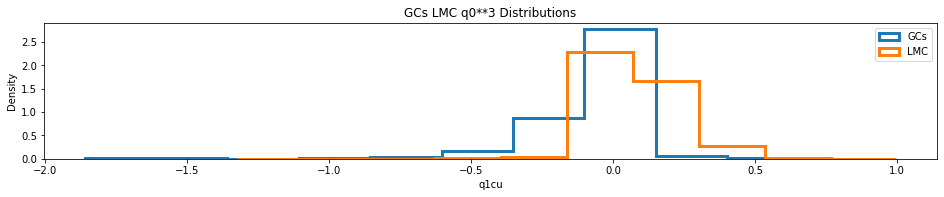

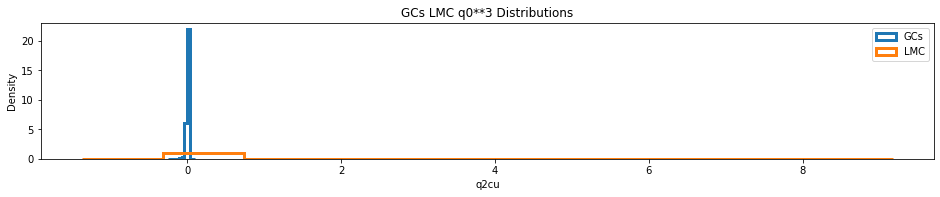

In [18]:
### q0cu
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[0]**3,density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[0]**2,density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0**3 Distributions')
plt.xlabel(r'q0cu')
plt.ylabel(r'Density')
plt.show()

### q1cu
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[1]**3,density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[1]**3,density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0**3 Distributions')
plt.xlabel(r'q1cu')
plt.ylabel(r'Density')
plt.show()

### q2cu
plt.figure(figsize=[16,2.5])
plt.hist(new_gcs.T[2]**3,density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(new_lmc.T[2]**3,density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0**3 Distributions')
plt.xlabel(r'q2cu')
plt.ylabel(r'Density')
plt.show()

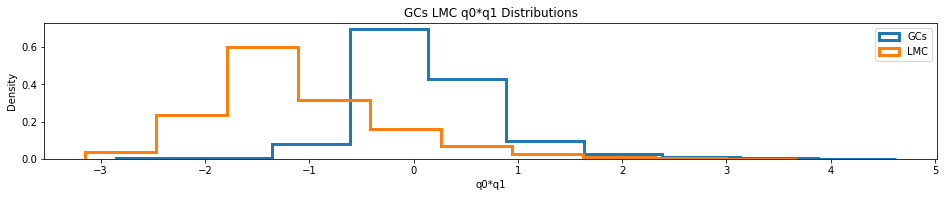

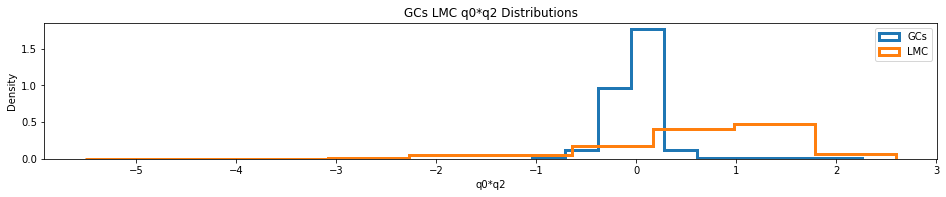

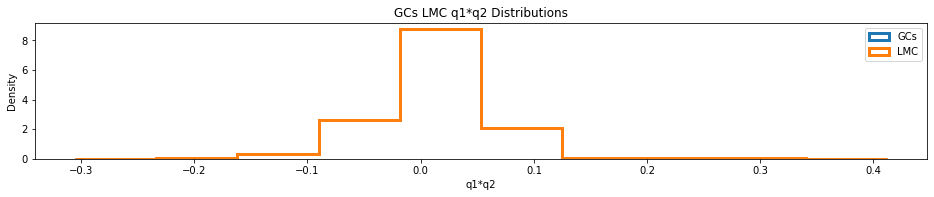

In [19]:
### q0*q1
plt.figure(figsize=[16,2.5])
plt.hist(np.multiply(new_gcs.T[0],new_gcs.T[1]),density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(np.multiply(new_lmc.T[0],new_lmc.T[1]),density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0*q1 Distributions')
plt.xlabel(r'q0*q1')
plt.ylabel(r'Density')
plt.show()

### q0*q2
plt.figure(figsize=[16,2.5])
plt.hist(np.multiply(new_gcs.T[0],new_gcs.T[2]),density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(np.multiply(new_lmc.T[0],new_lmc.T[2]),density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q0*q2 Distributions')
plt.xlabel(r'q0*q2')
plt.ylabel(r'Density')
plt.show()

### q1*q2
plt.figure(figsize=[16,2.5])
plt.hist(np.multiply(new_gcs.T[1],new_gcs.T[2]),density=True,lw=3.0,histtype='step',label='GCs')
plt.hist(np.multiply(new_gcs.T[1],new_gcs.T[2]),density=True,lw=3.0,histtype='step',label='LMC')

plt.legend()

plt.title(r'GCs LMC q1*q2 Distributions')
plt.xlabel(r'q1*q2')
plt.ylabel(r'Density')
plt.show()

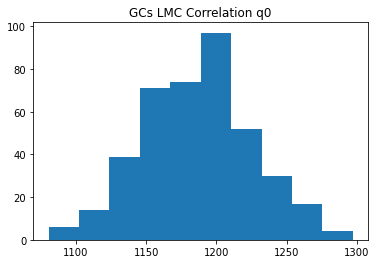

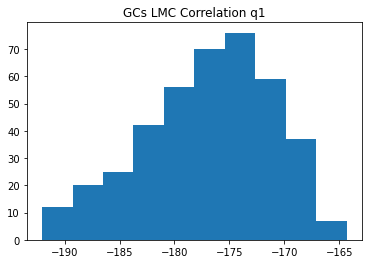

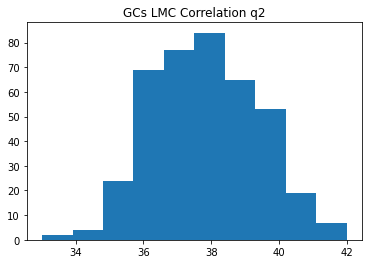

In [20]:
plt.hist(np.correlate(new_gcs.T[0],new_lmc.T[0]))
plt.title(r'GCs LMC Correlation q0')
plt.show()

plt.hist(np.correlate(new_gcs.T[1],new_lmc.T[1]))
plt.title(r'GCs LMC Correlation q1')
plt.show()

plt.hist(np.correlate(new_gcs.T[2],new_lmc.T[2]))
plt.title(r'GCs LMC Correlation q2')
plt.show()

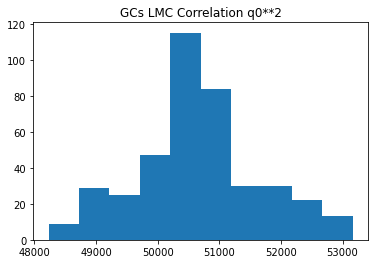

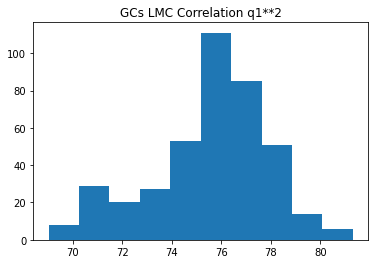

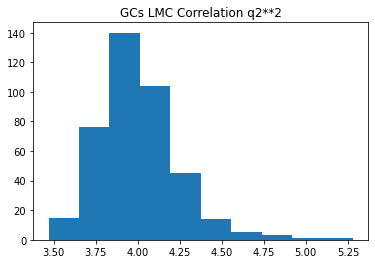

In [21]:
plt.hist(np.correlate(new_gcs.T[0]**2,new_lmc.T[0]**2))
plt.title(r'GCs LMC Correlation q0**2')
plt.show()

plt.hist(np.correlate(new_gcs.T[1]**2,new_lmc.T[1]**2))
plt.title(r'GCs LMC Correlation q1**2')
plt.show()

plt.hist(np.correlate(new_gcs.T[2]**2,new_lmc.T[2]**2))
plt.title(r'GCs LMC Correlation q2**2')
plt.show()

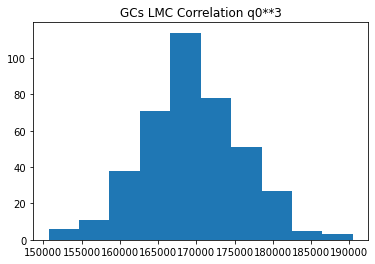

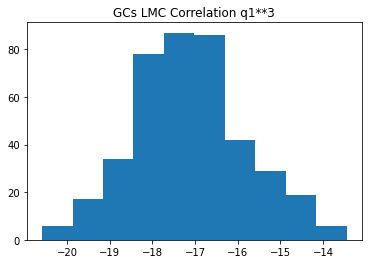

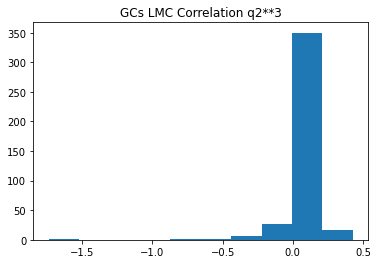

In [22]:
plt.hist(np.correlate(new_gcs.T[0]**3,new_lmc.T[0]**3))
plt.title(r'GCs LMC Correlation q0**3')
plt.show()

plt.hist(np.correlate(new_gcs.T[1]**3,new_lmc.T[1]**3))
plt.title(r'GCs LMC Correlation q1**3')
plt.show()

plt.hist(np.correlate(new_gcs.T[2]**3,new_lmc.T[2]**3))
plt.title(r'GCs LMC Correlation q2**3')
plt.show()

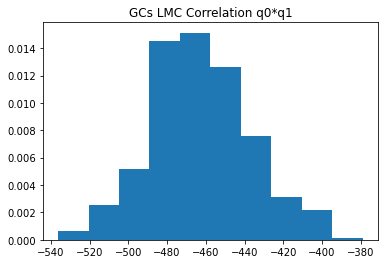

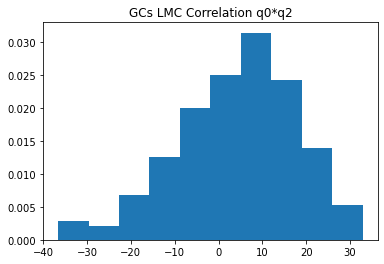

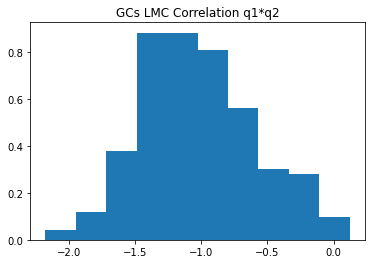

In [23]:
plt.hist(np.correlate(np.multiply(new_gcs.T[0],new_gcs.T[1]),np.multiply(new_lmc.T[0],new_lmc.T[1])),density=True)
plt.title(r'GCs LMC Correlation q0*q1')
plt.show()

plt.hist(np.correlate(np.multiply(new_gcs.T[0],new_gcs.T[2]),np.multiply(new_lmc.T[0],new_lmc.T[2])),density=True)
plt.title(r'GCs LMC Correlation q0*q2')
plt.show()

plt.hist(np.correlate(np.multiply(new_gcs.T[1],new_gcs.T[2]),np.multiply(new_lmc.T[1],new_lmc.T[2])),density=True)
plt.title(r'GCs LMC Correlation q1*q2')
plt.show()

In [24]:
ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['Cluster'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M3: NGC5272
    elif (gcs['Cluster'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['Cluster'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['Cluster'][i]=='M5'): 
        ngc_names.append('NGC5904')
    
    #M10: NGC6254
    elif (gcs['Cluster'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M12: NGC6218
    elif (gcs['Cluster'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['Cluster'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15: NGC7078
    elif (gcs['Cluster'][i]=='M15'): 
        ngc_names.append('NGC7078')
    
    #M19: NGC6273
    elif (gcs['Cluster'][i]=='M19'): 
        ngc_names.append('NGC6273')
    
    #M22: NGC6656
    elif (gcs['Cluster'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M53: NGC5024
    elif (gcs['Cluster'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M54: NGC6715
    elif (gcs['Cluster'][i]=='M54'): 
        ngc_names.append('NGC6715')
    
    #M55: NGC6809
    elif (gcs['Cluster'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68: NGC4590
    elif (gcs['Cluster'][i]=='M68'): 
        ngc_names.append('NGC4590')   
    
    #M71: NGC6838
    elif (gcs['Cluster'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['Cluster'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92: NGC6341
    elif (gcs['Cluster'][i]=='M92'): 
        ngc_names.append('NGC5904')
    
    #M107: NGC6171
    elif (gcs['Cluster'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #omegaCen: NGC5139
    elif (gcs['Cluster'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['Cluster'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, gcs_ind = np.intersect1d(supp2['Cluster'], ngc_names, return_indices=True)

In [25]:
ngc_names[gcs_ind]

array(['NGC1851', 'NGC2808', 'NGC3201', 'NGC4147', 'NGC4590', 'NGC5024',
       'NGC5053', 'NGC5139', 'NGC5272', 'NGC5466', 'NGC5904', 'NGC6121',
       'NGC6144', 'NGC6171', 'NGC6205', 'NGC6218', 'NGC6254', 'NGC6304',
       'NGC6388', 'NGC6397', 'NGC6441', 'NGC6656', 'NGC6715', 'NGC6723',
       'NGC6752', 'NGC6809', 'NGC6838', 'NGC7078', 'NGC7089'], dtype='<U8')

In [26]:
gc_dist = []
gc_dist_err = []
for i in s2_ind:
    distribution = []
    for j in range(100):
        distance = 10**((add_noise(supp2['Dist'][i],supp2['Dist_Sigma'][i])+5-
                         add_noise(supp2['Av'][i],supp2['Av_Sigma'][i]))/5.)
        distribution.append(distance)
    gc_dist.append(np.median(distribution))
    gc_dist_err.append(afunc.mad(distribution))
    
ngc_dist = np.zeros(len(ngc_names))
ngc_dist_err = np.zeros(len(ngc_names))

for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][0])):
    ngc_dist[j] = gc_dist[0]
    ngc_dist_err[j] = gc_dist_err[0]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][1])):
    ngc_dist[j] = gc_dist[1]
    ngc_dist_err[j] = gc_dist_err[1]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][2])):
    ngc_dist[j] = gc_dist[2]
    ngc_dist_err[j] = gc_dist_err[2]
# for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][3])):
ngc_dist[366] = gc_dist[3]
ngc_dist_err[366] = gc_dist_err[3]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][4])):
    ngc_dist[j] = gc_dist[4]
    ngc_dist_err[j] = gc_dist_err[4]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][5])):
    ngc_dist[j] = gc_dist[5]
    ngc_dist_err[j] = gc_dist_err[5]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][6])):
    ngc_dist[j] = gc_dist[6]
    ngc_dist_err[j] = gc_dist_err[6]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][7])):
    ngc_dist[j] = gc_dist[7]
    ngc_dist_err[j] = gc_dist_err[7]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][8])):
    ngc_dist[j] = gc_dist[8]
    ngc_dist_err[j] = gc_dist_err[8]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][9])):
    ngc_dist[j] = gc_dist[9]
    ngc_dist_err[j] = gc_dist_err[9]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][10])):
    ngc_dist[j] = gc_dist[10]
    ngc_dist_err[j] = gc_dist_err[10]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][11])):
    ngc_dist[j] = gc_dist[11]
    ngc_dist_err[j] = gc_dist_err[11]
# for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][12])):
ngc_dist[1492] = gc_dist[12]
ngc_dist_err[1492] = gc_dist_err[12]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][13])):
    ngc_dist[j] = gc_dist[13]
    ngc_dist_err[j] = gc_dist_err[13]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][14])):
    ngc_dist[j] = gc_dist[14]
    ngc_dist_err[j] = gc_dist_err[14]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][15])):
    ngc_dist[j] = gc_dist[15]
    ngc_dist_err[j] = gc_dist_err[15]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][16])):
    ngc_dist[j] = gc_dist[16]
    ngc_dist_err[j] = gc_dist_err[16]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][17])):
    ngc_dist[j] = gc_dist[17]
    ngc_dist_err[j] = gc_dist_err[17]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][18])):
    ngc_dist[j] = gc_dist[18]
    ngc_dist_err[j] = gc_dist_err[18]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][19])):
    ngc_dist[j] = gc_dist[19]
    ngc_dist_err[j] = gc_dist_err[19]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][20])):
    ngc_dist[j] = gc_dist[20]
    ngc_dist_err[j] = gc_dist_err[20]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][21])):
    ngc_dist[j] = gc_dist[21]
    ngc_dist_err[j] = gc_dist_err[21]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][22])):
    ngc_dist[j] = gc_dist[22]
    ngc_dist_err[j] = gc_dist_err[22]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][23])):
    ngc_dist[j] = gc_dist[23]
    ngc_dist_err[j] = gc_dist_err[23]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][24])):
    ngc_dist[j] = gc_dist[24]
    ngc_dist_err[j] = gc_dist_err[24]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][25])):
    ngc_dist[j] = gc_dist[25]
    ngc_dist_err[j] = gc_dist_err[25]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][26])):
    ngc_dist[j] = gc_dist[26]
    ngc_dist_err[j] = gc_dist_err[26]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][27])):
    ngc_dist[j] = gc_dist[27]
    ngc_dist_err[j] = gc_dist_err[27]
for j in np.squeeze(np.where(ngc_names==ngc_names[gcs_ind][28])):
    ngc_dist[j] = gc_dist[28]
    ngc_dist_err[j] = gc_dist_err[28]
        

(array([3.000e+00, 1.000e+01, 1.500e+01, 4.800e+01, 5.230e+02, 1.468e+03,
        1.090e+02, 6.000e+00, 2.000e+00, 1.000e+00]),
 array([-30.27988769, -24.92814584, -19.57640399, -14.22466214,
         -8.87292029,  -3.52117844,   1.83056341,   7.18230526,
         12.53404711,  17.88578896,  23.23753082]),
 <BarContainer object of 10 artists>)

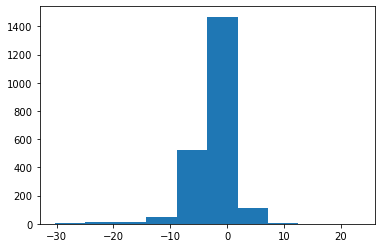

In [27]:
plt.hist(ngc_dist/1000.-gcs['r_sph'])

(array([925., 888., 285.,  38.,  26.,  11.,   4.,   5.,   2.,   1.]),
 array([ 1.2047 ,  5.75034, 10.29598, 14.84162, 19.38726, 23.9329 ,
        28.47854, 33.02418, 37.56982, 42.11546, 46.6611 ]),
 <BarContainer object of 10 artists>)

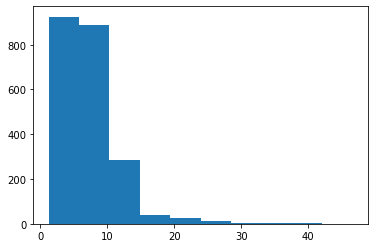

In [28]:
plt.hist(gcs['distmed'])

In [29]:
gcs['sigma_dist']

array([0.2242    , 0.18559999, 0.24510001, ..., 0.9995    , 1.00359998,
       0.341     ])

In [30]:
len(supp2['Cluster'][s2_ind])

29

In [31]:
###############################
### Some Calcuations Needed ###
###############################

# c_icrs = SkyCoord(ra=lmc['RA']*u.degree, dec=lmc['DEC']*u.degree)
# c_ms = c_icrs.transform_to(ms.MagellanicStream)
# ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

# for i in range(len(ms_lg)):
#     if ms_lg[i]-360<-180:
#         ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [32]:
def find_ages(z1,z2,z3):    
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
    p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    return age

def mad_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu'
    p = [9.62380331e+00,-4.37017699e-02,-8.10474922e-02,-3.01927839e+00,3.66311343e-02,1.13899497e-01,
         -9.24659108e-03,2.08472233e-02,6.99173508e-01,3.40709987e-03,2.41138017e-03]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+
           p[6]*(x1**2)+p[7]*(x2**2)+p[8]*(x3**2)+
           p[9]*(x1**3)+p[10]*(x2**3))
    return age

def ll_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu' 'x3cu'
    p = [9.62345764e+00,-4.30768983e-02,-8.06826028e-02,-3.01563712e+00,3.65508436e-02,1.17097905e-01,
         -2.59253472e-02,-8.98018594e-03,2.10598963e-02,7.16404583e-01,3.32627539e-03,1.34864314e-03,
         -3.07136600e-02]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
           p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
           p[10]*(x1**3)+p[11]*(x2**3)+p[12]*(x3**3))
    return age

def max_resid_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x1sq' 'x2sq' 'x3cu'
    p = [9.62671618e+00,-3.76516348e-02,-7.73334895e-02,-3.03980891e+00,3.45423253e-02,8.77085003e-02,
         -6.14819060e-03,2.43493988e-02,1.29436784e+00]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+
           p[6]*(x1**2)+p[7]*(x2**2)+
           p[8]*(x3**3))
    return age

def current_age(x1,x2,x3):
    #'x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x2cu' 'x3cu'
    p = [9.62160564e+00,-3.73279863e-02,-8.03408138e-02,-3.01132874e+00,3.47946523e-02,1.07568186e-01,
         -2.82038911e-02,-6.71667916e-03,2.32342481e-02,7.17749242e-01,5.41993609e-04,-3.22534784e-02]
    age = (p[0]+
           p[1]*x1+p[2]*x2+p[3]*x3+
           p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
           p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
           p[10]*(x2**3)+p[11]*(x3**3))
    return age

In [33]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [34]:
predage = []
for i in range(len(parsec)):
    q0 = new_par[i][0]
    q1 = new_par[i][1]
    q2 = new_par[i][2]
    predage.append(find_ages(q0,q1,q2))    
predage = np.asarray(predage)

pred_cur_age = []
for i in range(len(parsec)):
    q0 = new_par[i][0]
    q1 = new_par[i][1]
    q2 = new_par[i][2]
    pred_cur_age.append(current_age(q0,q1,q2))
    
pred_cur_age = np.asarray(pred_cur_age)

pred_ll_age = []
for i in range(len(parsec)):
    q0 = new_par[i][0]
    q1 = new_par[i][1]
    q2 = new_par[i][2]
    pred_ll_age.append(ll_age(q0,q1,q2))
    
pred_ll_age = np.asarray(pred_ll_age)

pred_max_resid_age = []
for i in range(len(parsec)):
    q0 = new_par[i][0]
    q1 = new_par[i][1]
    q2 = new_par[i][2]
    pred_max_resid_age.append(max_resid_age(q0,q1,q2))
    
pred_max_resid_age = np.asarray(pred_max_resid_age)

pred_mad_age = []
for i in range(len(parsec)):
    q0 = new_par[i][0]
    q1 = new_par[i][1]
    q2 = new_par[i][2]
    pred_mad_age.append(mad_age(q0,q1,q2))
    
pred_mad_age = np.asarray(pred_mad_age)

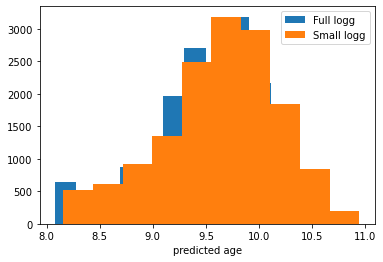

In [35]:
plt.hist(predage,label='Full logg')
plt.hist(pred_cur_age,label='Small logg')
plt.xlabel(r'predicted age')
plt.legend()

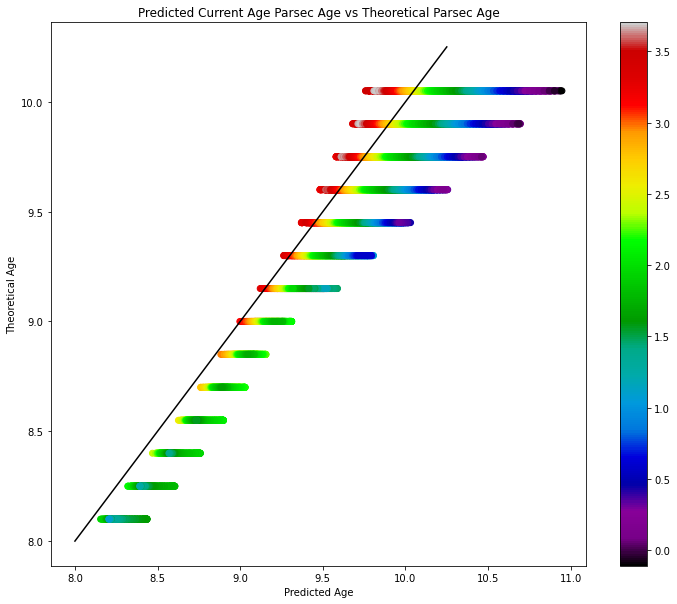

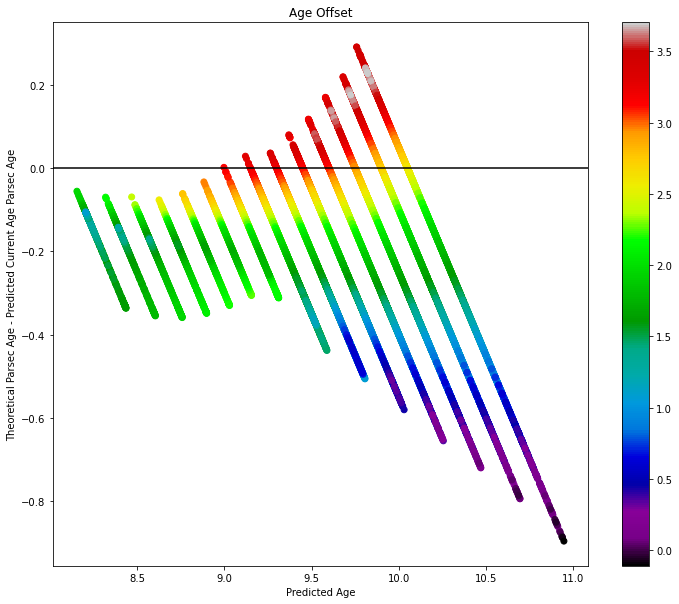

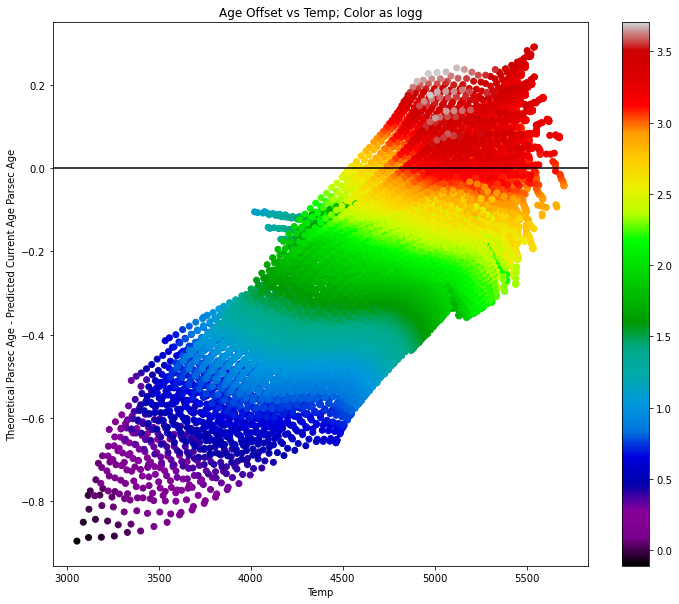

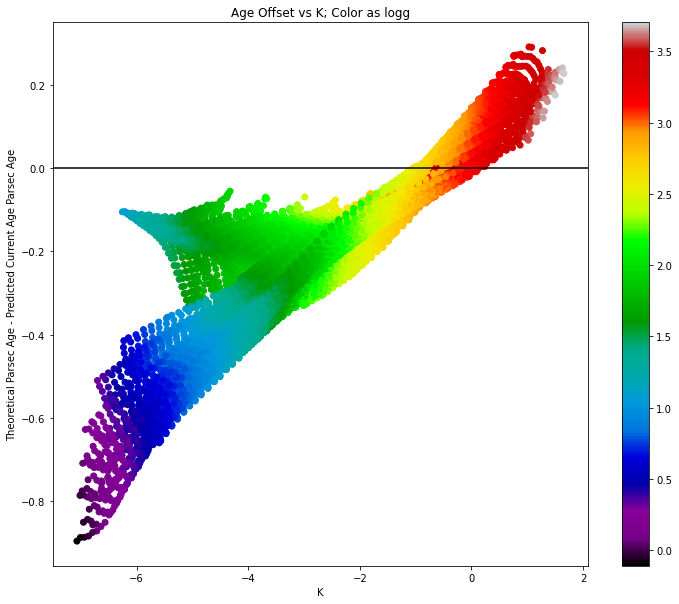

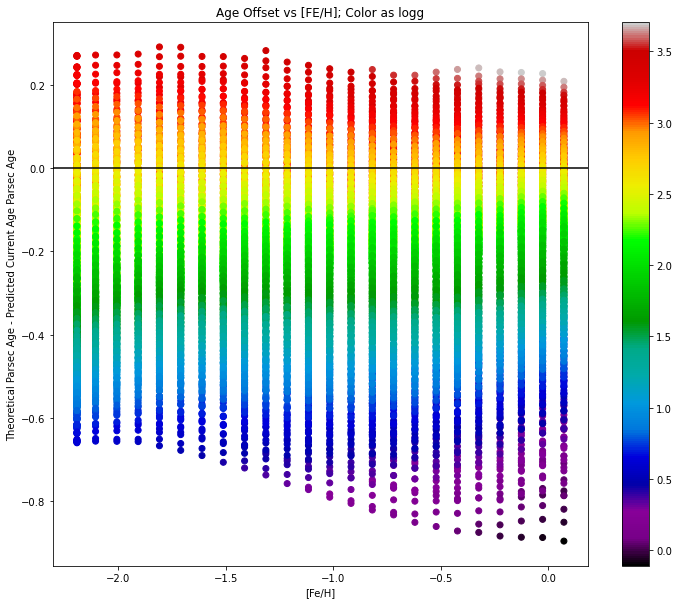

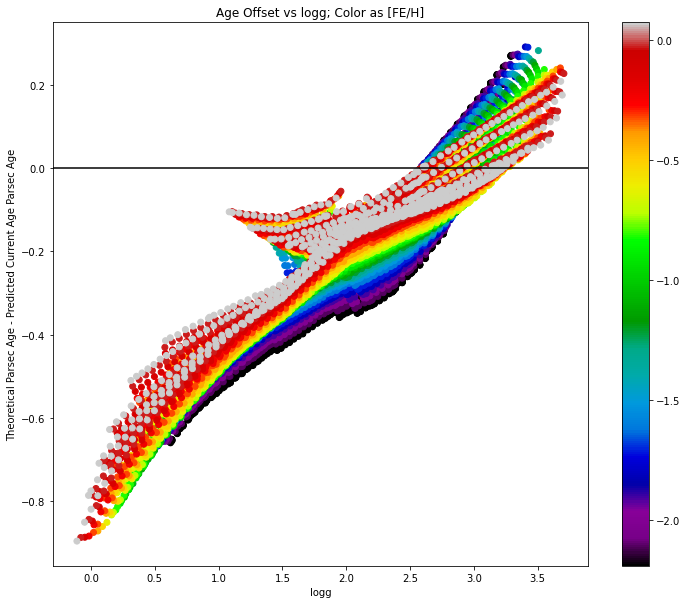

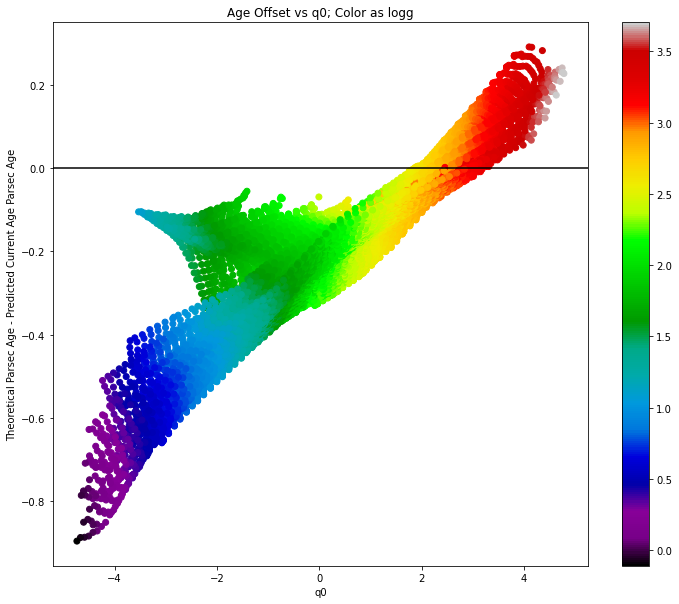

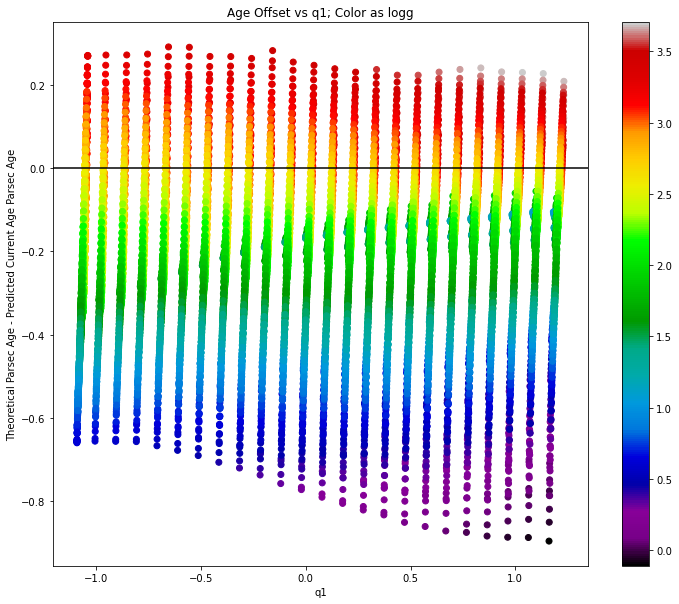

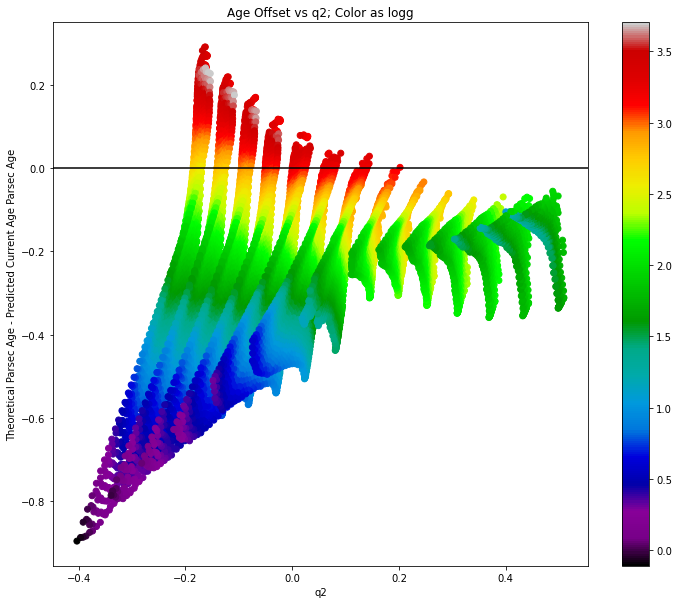

In [36]:
#######################################
### PARSEC Theoretical vs Predicted ###
#######################################

### Predicted vs Theoretical
plt.figure(figsize=[12,10])
plt.scatter(pred_cur_age,parsec['logAge'],c=parsec['logg'],cmap='nipy_spectral')
plt.plot([8,10.25],[8,10.25],c='k')
plt.colorbar()

plt.title(r'Predicted Current Age Parsec Age vs Theoretical Parsec Age')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Age')
plt.savefig('parsec_pred_v_theo.pdf',bbox_inches='tight')
plt.show()

### Offset
plt.figure(figsize=[12,10])
plt.scatter(pred_cur_age,parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_pred.pdf',bbox_inches='tight')
plt.show()

### Offset vs Temp
plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe'],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs Temp; Color as logg')
plt.xlabel(r'Temp')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_temp.pdf',bbox_inches='tight')
plt.show()

### Offset vs K
plt.figure(figsize=[12,10])
plt.scatter(parsec['Ksmag'],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs K; Color as logg')
plt.xlabel(r'K')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_K.pdf',bbox_inches='tight')
plt.show()

### Offset vs [Fe/H]
plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs [FE/H]; Color as logg')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_feh.pdf',bbox_inches='tight')
plt.show()

### Offset vs Logg
plt.figure(figsize=[12,10])
plt.scatter(parsec['logg'],parsec['logAge']-pred_cur_age,c=parsec['MH'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs logg; Color as [FE/H]')
plt.xlabel(r'logg')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_logg.pdf',bbox_inches='tight')
plt.show()

### Offset vs q0
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[0],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q0; Color as logg')
plt.xlabel(r'q0')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.show()

### Offset vs q1
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[1],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q1; Color as logg')
plt.xlabel(r'q1')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.show()

### Offset vs q2
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[2],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q2; Color as logg')
plt.xlabel(r'q2')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.show()

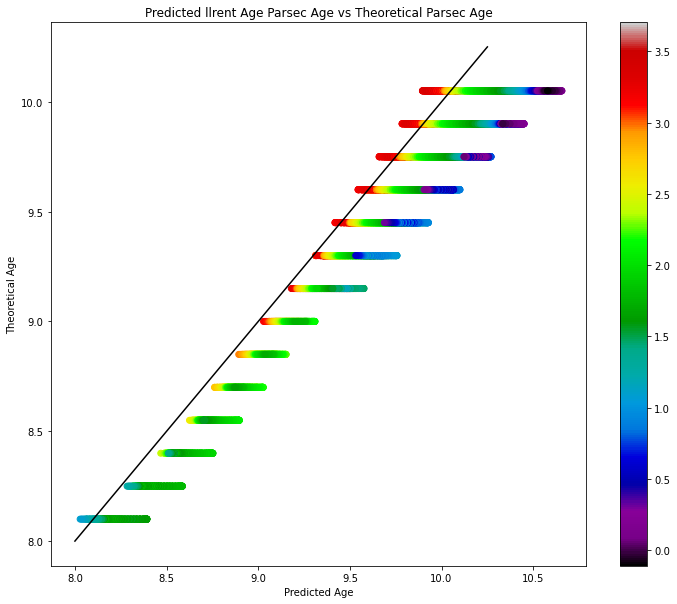

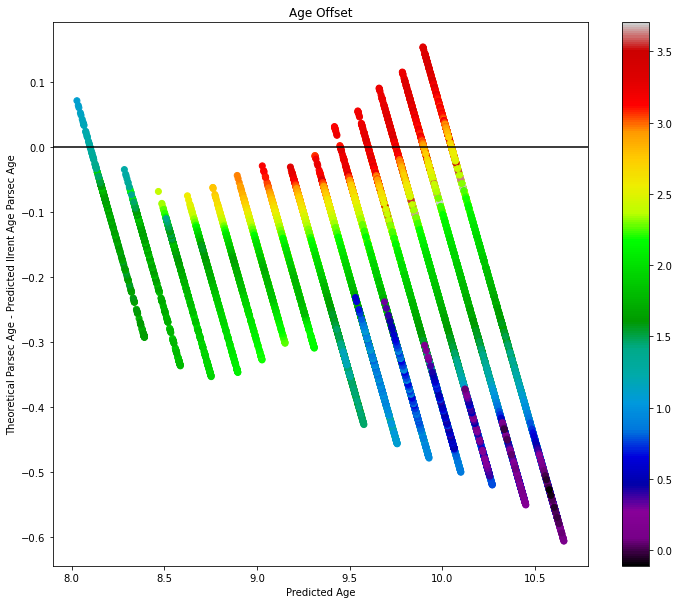

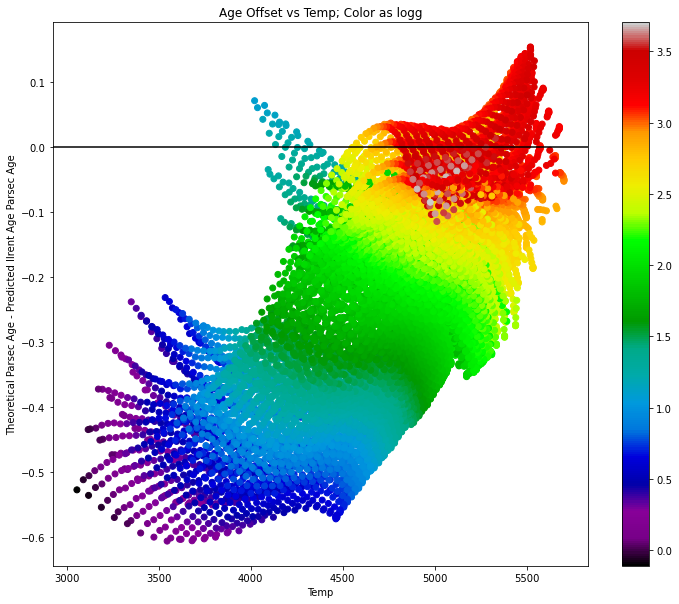

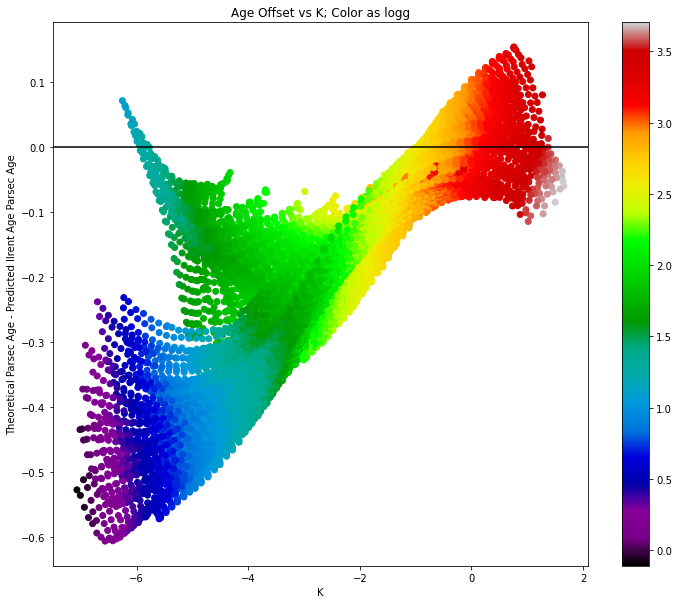

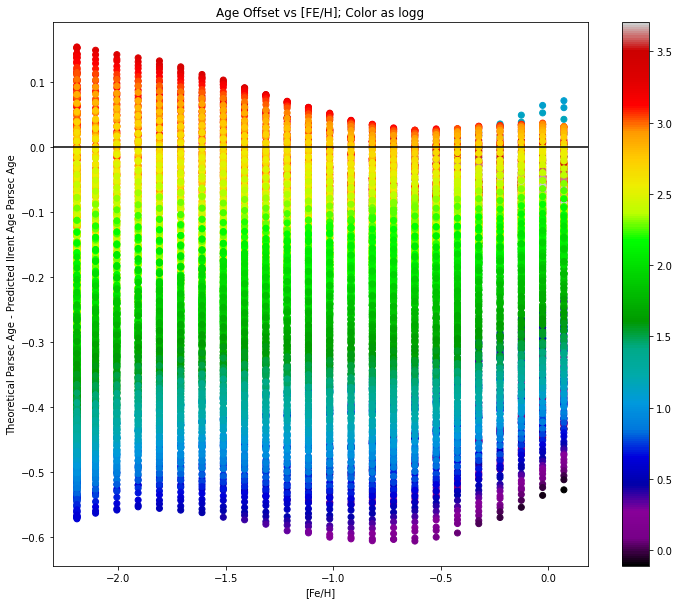

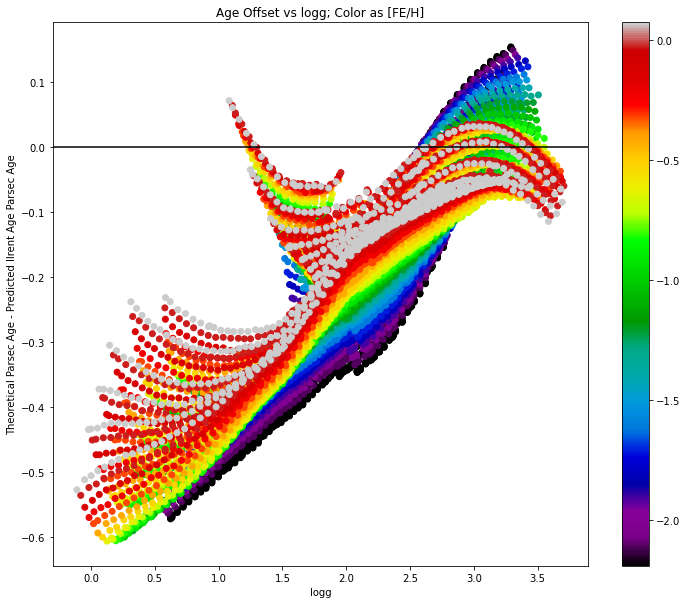

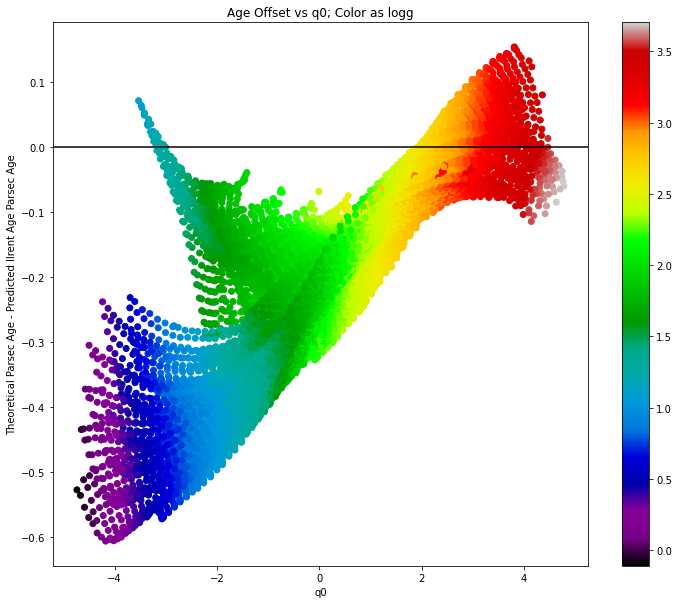

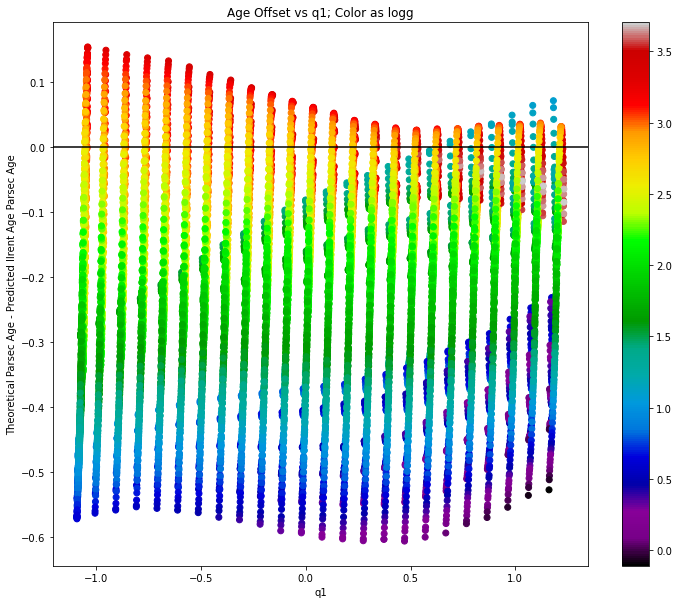

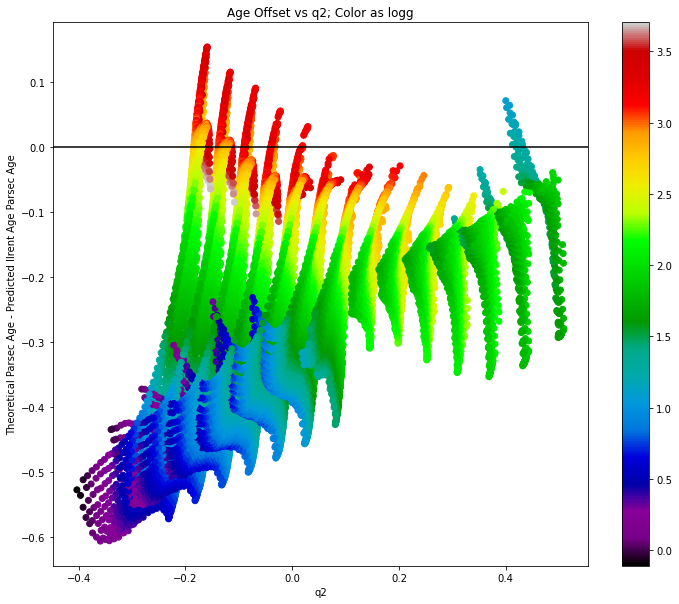

In [37]:
### Predicted vs Theoretical
plt.figure(figsize=[12,10])
plt.scatter(pred_ll_age,parsec['logAge'],c=parsec['logg'],cmap='nipy_spectral')
plt.plot([8,10.25],[8,10.25],c='k')
plt.colorbar()

plt.title(r'Predicted llrent Age Parsec Age vs Theoretical Parsec Age')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Age')
plt.savefig('parsec_pred_v_theo.pdf',bbox_inches='tight')
plt.show()

### Offset
plt.figure(figsize=[12,10])
plt.scatter(pred_ll_age,parsec['logAge']-pred_ll_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.savefig('parsec_offset_v_pred.pdf',bbox_inches='tight')
plt.show()

### Offset vs Temp
plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe'],parsec['logAge']-pred_ll_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs Temp; Color as logg')
plt.xlabel(r'Temp')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.savefig('parsec_offset_v_temp.pdf',bbox_inches='tight')
plt.show()

### Offset vs K
plt.figure(figsize=[12,10])
plt.scatter(parsec['Ksmag'],parsec['logAge']-pred_ll_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs K; Color as logg')
plt.xlabel(r'K')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.savefig('parsec_offset_v_K.pdf',bbox_inches='tight')
plt.show()

### Offset vs [Fe/H]
plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['logAge']-pred_ll_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs [FE/H]; Color as logg')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.savefig('parsec_offset_v_feh.pdf',bbox_inches='tight')
plt.show()

### Offset vs Logg
plt.figure(figsize=[12,10])
plt.scatter(parsec['logg'],parsec['logAge']-pred_ll_age,c=parsec['MH'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs logg; Color as [FE/H]')
plt.xlabel(r'logg')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.savefig('parsec_offset_v_logg.pdf',bbox_inches='tight')
plt.show()

### Offset vs q0
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[0],parsec['logAge']-pred_ll_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q0; Color as logg')
plt.xlabel(r'q0')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.show()

### Offset vs q1
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[1],parsec['logAge']-pred_ll_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q1; Color as logg')
plt.xlabel(r'q1')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.show()

### Offset vs q2
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[2],parsec['logAge']-pred_ll_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q2; Color as logg')
plt.xlabel(r'q2')
plt.ylabel(r'Theoretical Parsec Age - Predicted llrent Age Parsec Age')
plt.show()

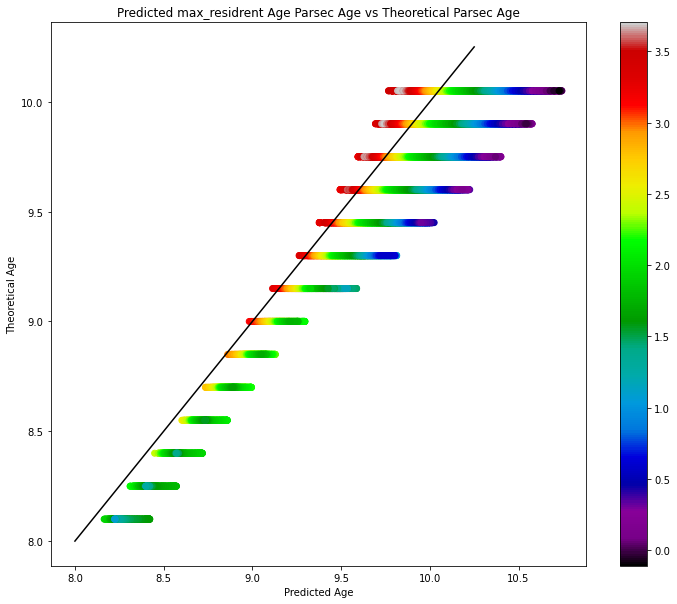

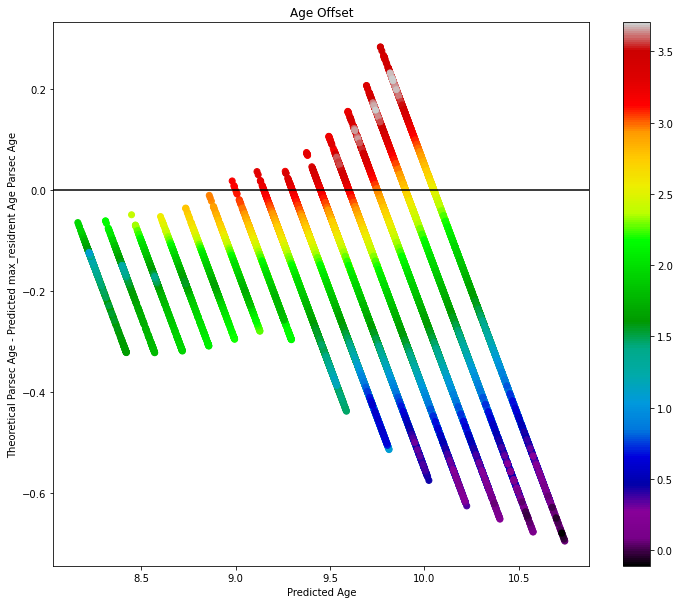

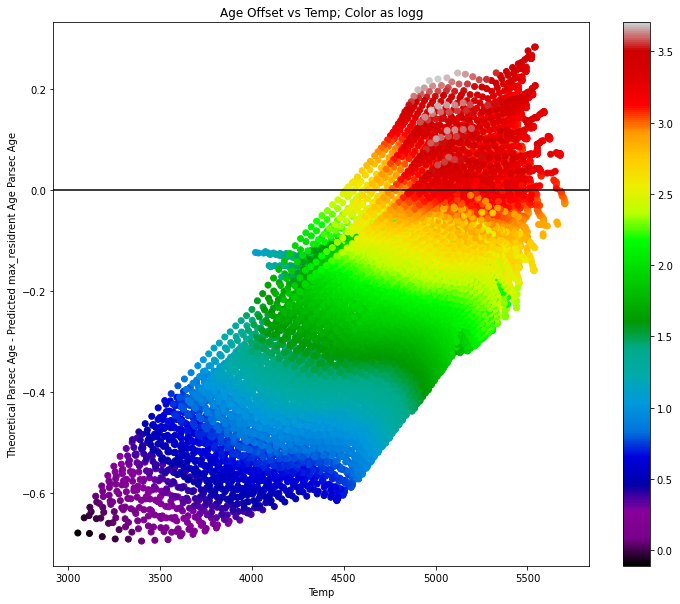

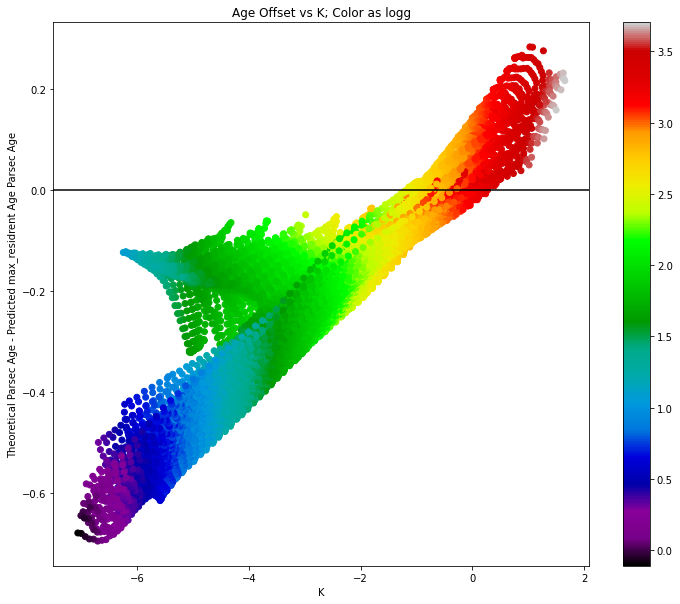

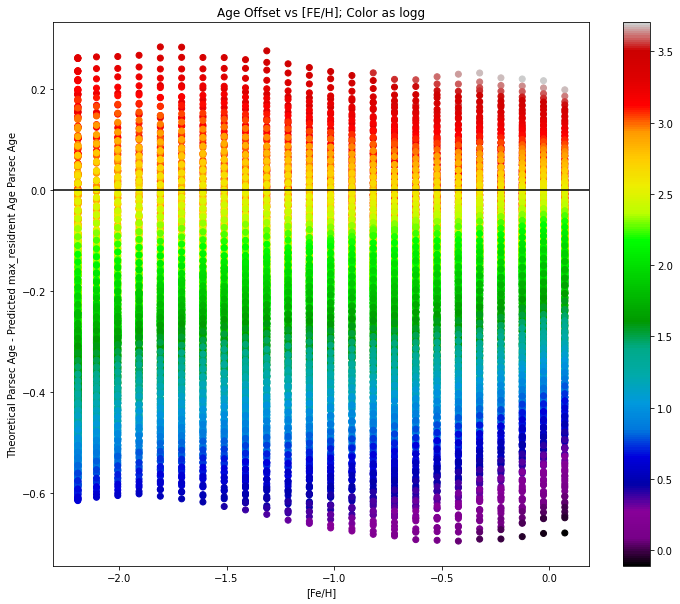

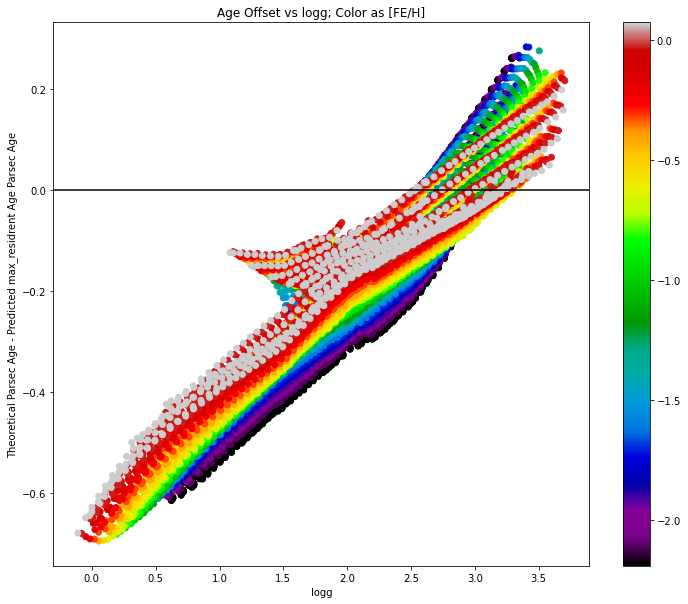

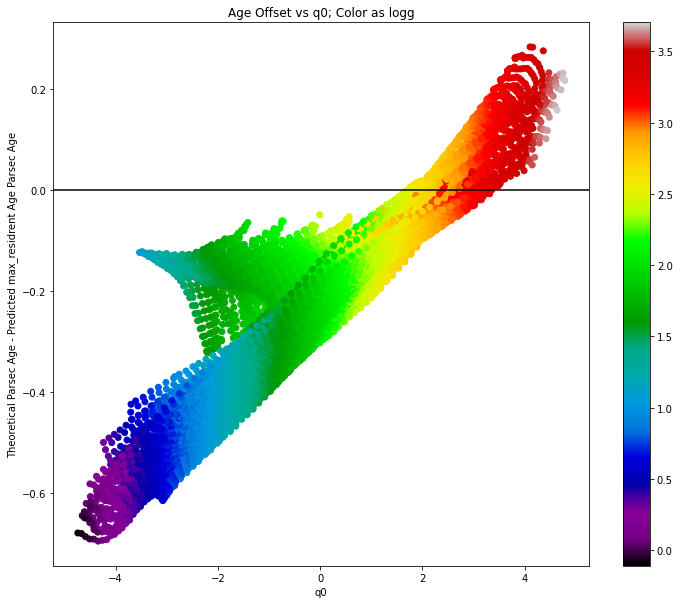

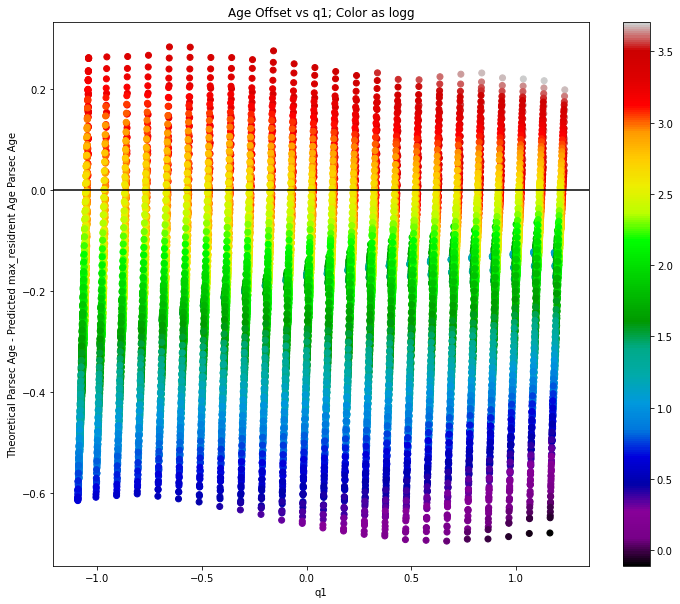

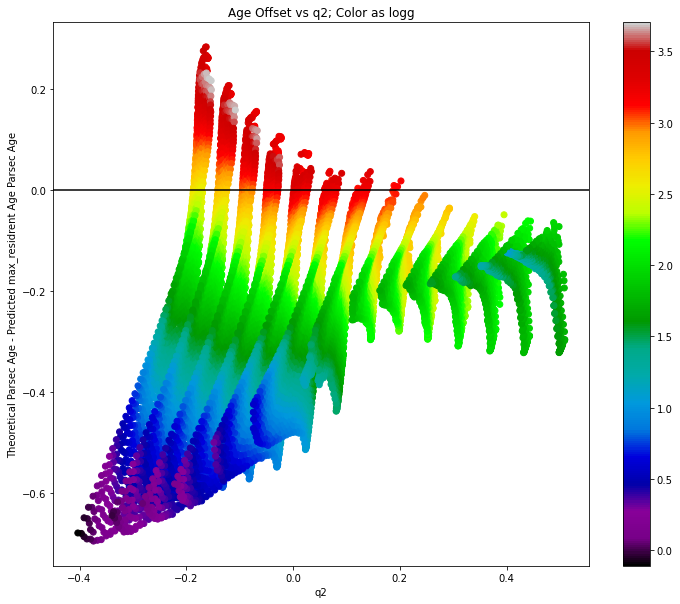

In [38]:
### Predicted vs Theoretical
plt.figure(figsize=[12,10])
plt.scatter(pred_max_resid_age,parsec['logAge'],c=parsec['logg'],cmap='nipy_spectral')
plt.plot([8,10.25],[8,10.25],c='k')
plt.colorbar()

plt.title(r'Predicted max_residrent Age Parsec Age vs Theoretical Parsec Age')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Age')
plt.savefig('parsec_pred_v_theo.pdf',bbox_inches='tight')
plt.show()

### Offset
plt.figure(figsize=[12,10])
plt.scatter(pred_max_resid_age,parsec['logAge']-pred_max_resid_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.savefig('parsec_offset_v_pred.pdf',bbox_inches='tight')
plt.show()

### Offset vs Temp
plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe'],parsec['logAge']-pred_max_resid_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs Temp; Color as logg')
plt.xlabel(r'Temp')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.savefig('parsec_offset_v_temp.pdf',bbox_inches='tight')
plt.show()

### Offset vs K
plt.figure(figsize=[12,10])
plt.scatter(parsec['Ksmag'],parsec['logAge']-pred_max_resid_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs K; Color as logg')
plt.xlabel(r'K')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.savefig('parsec_offset_v_K.pdf',bbox_inches='tight')
plt.show()

### Offset vs [Fe/H]
plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['logAge']-pred_max_resid_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs [FE/H]; Color as logg')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.savefig('parsec_offset_v_feh.pdf',bbox_inches='tight')
plt.show()

### Offset vs Logg
plt.figure(figsize=[12,10])
plt.scatter(parsec['logg'],parsec['logAge']-pred_max_resid_age,c=parsec['MH'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs logg; Color as [FE/H]')
plt.xlabel(r'logg')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.savefig('parsec_offset_v_logg.pdf',bbox_inches='tight')
plt.show()

### Offset vs q0
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[0],parsec['logAge']-pred_max_resid_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q0; Color as logg')
plt.xlabel(r'q0')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.show()

### Offset vs q1
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[1],parsec['logAge']-pred_max_resid_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q1; Color as logg')
plt.xlabel(r'q1')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.show()

### Offset vs q2
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[2],parsec['logAge']-pred_max_resid_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q2; Color as logg')
plt.xlabel(r'q2')
plt.ylabel(r'Theoretical Parsec Age - Predicted max_residrent Age Parsec Age')
plt.show()

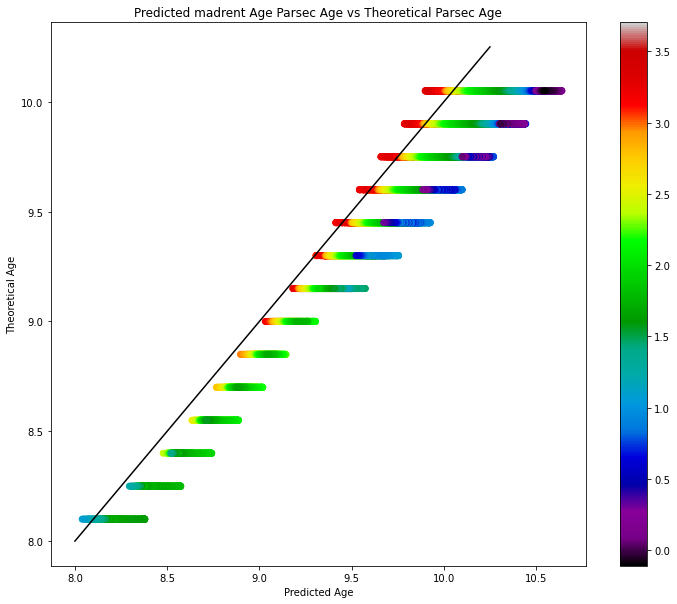

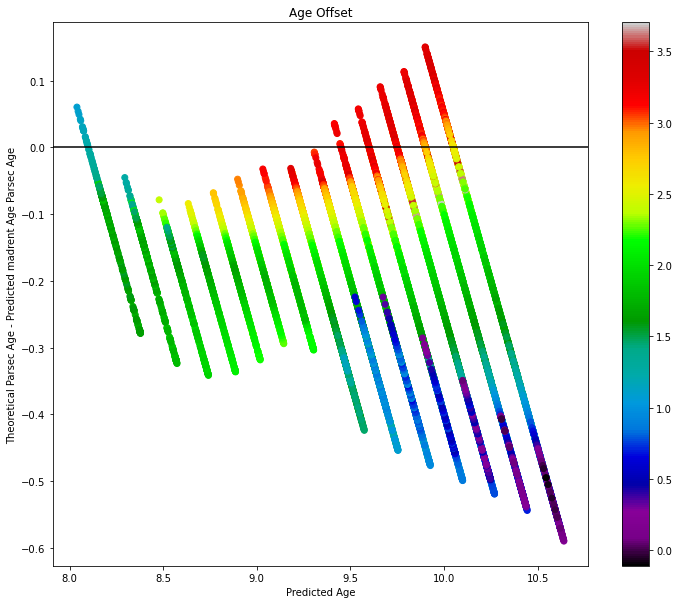

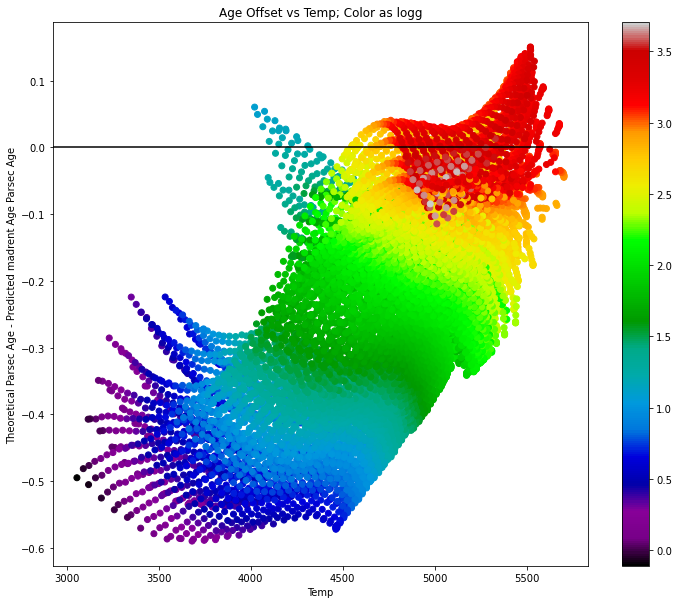

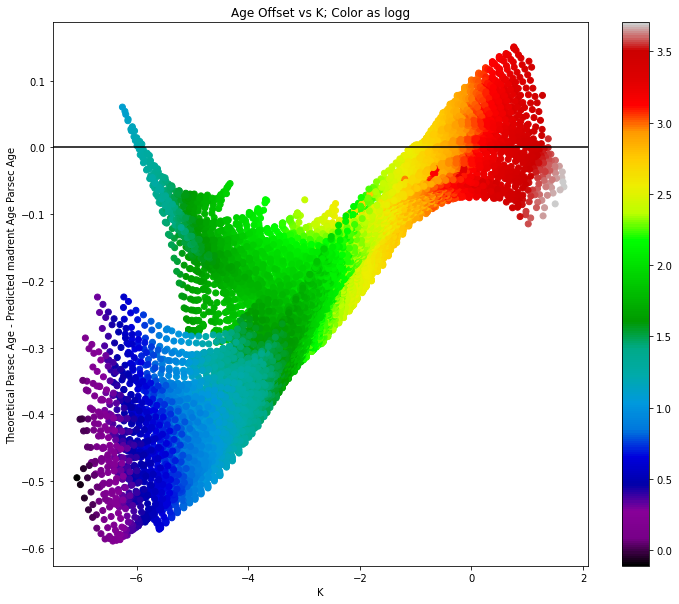

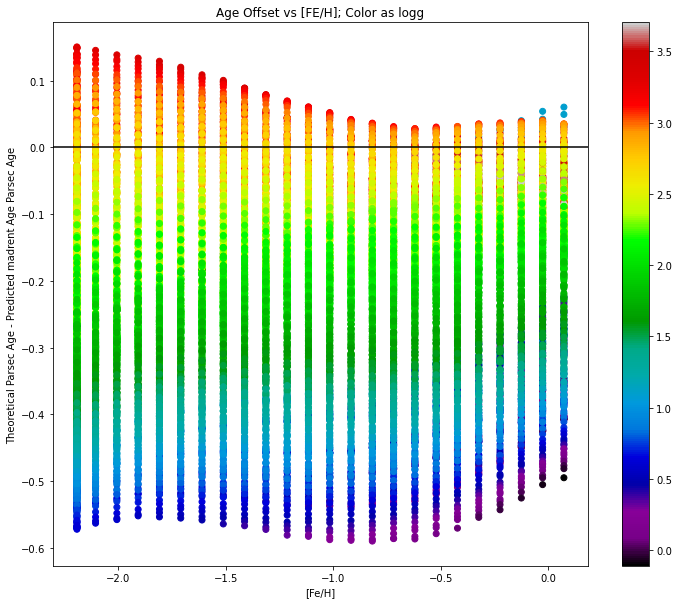

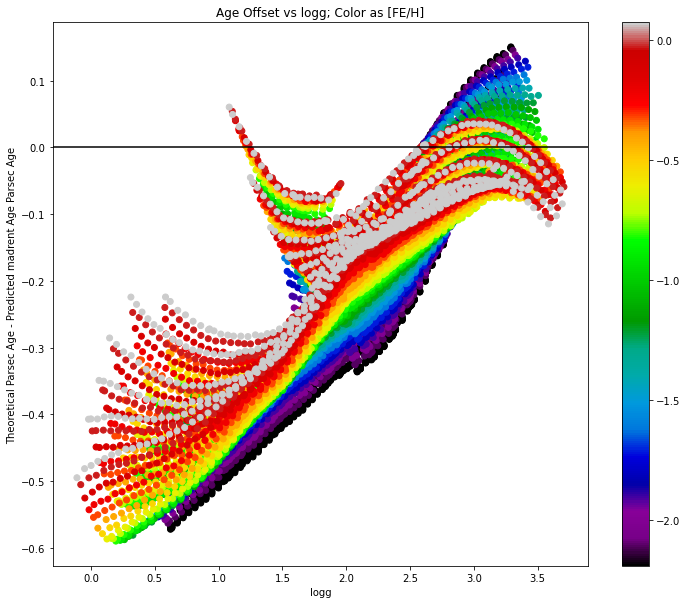

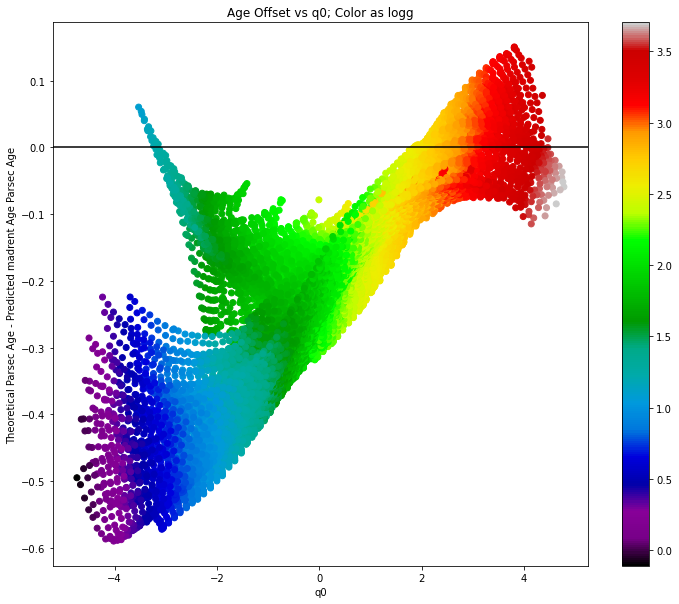

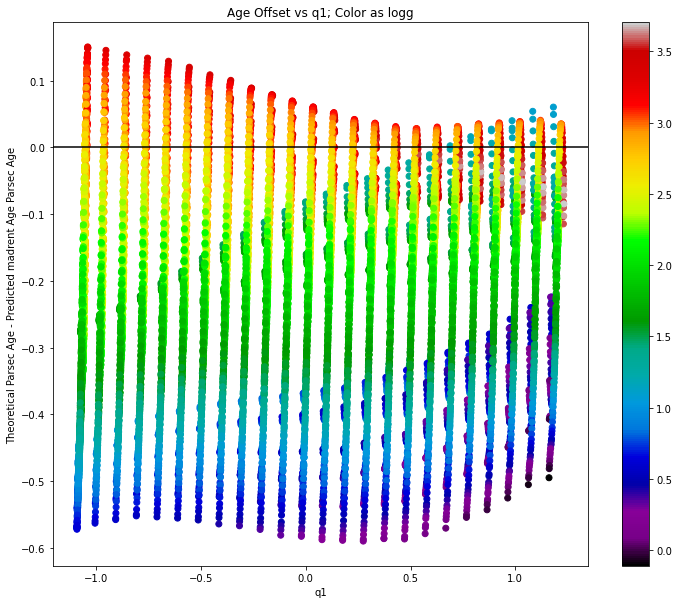

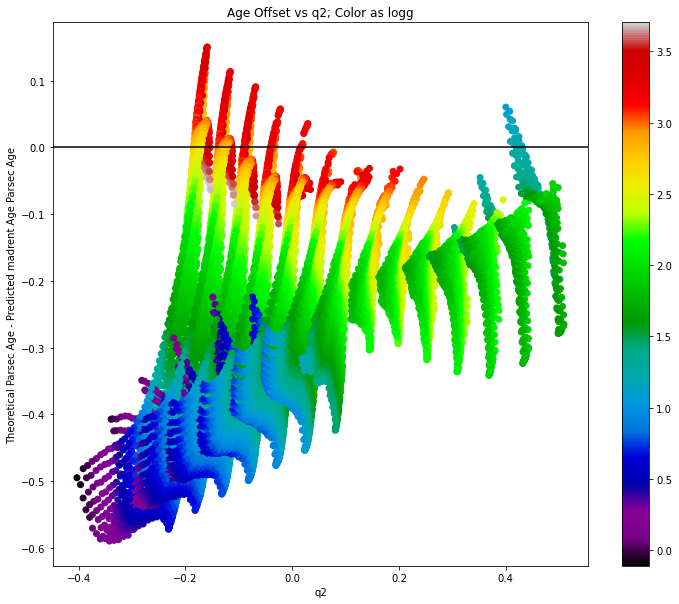

In [39]:
### Predicted vs Theoretical
plt.figure(figsize=[12,10])
plt.scatter(pred_mad_age,parsec['logAge'],c=parsec['logg'],cmap='nipy_spectral')
plt.plot([8,10.25],[8,10.25],c='k')
plt.colorbar()

plt.title(r'Predicted madrent Age Parsec Age vs Theoretical Parsec Age')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Age')
plt.savefig('parsec_pred_v_theo.pdf',bbox_inches='tight')
plt.show()

### Offset
plt.figure(figsize=[12,10])
plt.scatter(pred_mad_age,parsec['logAge']-pred_mad_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.savefig('parsec_offset_v_pred.pdf',bbox_inches='tight')
plt.show()

### Offset vs Temp
plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe'],parsec['logAge']-pred_mad_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs Temp; Color as logg')
plt.xlabel(r'Temp')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.savefig('parsec_offset_v_temp.pdf',bbox_inches='tight')
plt.show()

### Offset vs K
plt.figure(figsize=[12,10])
plt.scatter(parsec['Ksmag'],parsec['logAge']-pred_mad_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs K; Color as logg')
plt.xlabel(r'K')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.savefig('parsec_offset_v_K.pdf',bbox_inches='tight')
plt.show()

### Offset vs [Fe/H]
plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['logAge']-pred_mad_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs [FE/H]; Color as logg')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.savefig('parsec_offset_v_feh.pdf',bbox_inches='tight')
plt.show()

### Offset vs Logg
plt.figure(figsize=[12,10])
plt.scatter(parsec['logg'],parsec['logAge']-pred_mad_age,c=parsec['MH'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs logg; Color as [FE/H]')
plt.xlabel(r'logg')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.savefig('parsec_offset_v_logg.pdf',bbox_inches='tight')
plt.show()

### Offset vs q0
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[0],parsec['logAge']-pred_mad_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q0; Color as logg')
plt.xlabel(r'q0')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.show()

### Offset vs q1
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[1],parsec['logAge']-pred_mad_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q1; Color as logg')
plt.xlabel(r'q1')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.show()

### Offset vs q2
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[2],parsec['logAge']-pred_mad_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q2; Color as logg')
plt.xlabel(r'q2')
plt.ylabel(r'Theoretical Parsec Age - Predicted madrent Age Parsec Age')
plt.show()

In [40]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

# clus = np.where(gcs['Cluster']=='NGC3201')

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = gcs['distmed'][i]
    dist_err = gcs['sigma_dist'][i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = add_noise(dist,dist_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
#         am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
devs = np.asarray(devs)
parages = np.asarray(parages)

In [41]:
mad_age_dist = []
ll_age_dist = []
max_resid_age_dist = []
current_age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

for i in tqdm_notebook(range(len(gcs)),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = gcs['distmed'][i]
    dist_err = gcs['sigma_dist'][i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    aM = gcs['ALPHA_M'][i]
    aM_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_mad_ages = []
    noise_ll_ages = []
    noise_max_resid_ages = []
    noise_current_ages = []
    
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err)
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
#         _, _, dist = afunc.gcsdisk_cart(ra,dec)
        dist_new = add_noise(dist,dist_err)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        aM_new = add_noise(aM,aM_err)
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,aM_new),lgg_new]))
        
    xs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(xs)):
        noise_mad_ages.append(mad_age(xs[l][0],xs[l][1],xs[l][2]))
        noise_ll_ages.append(ll_age(xs[l][0],xs[l][1],xs[l][2]))
        noise_max_resid_ages.append(max_resid_age(xs[l][0],xs[l][1],xs[l][2]))
        noise_current_ages.append(current_age(xs[l][0],xs[l][1],xs[l][2]))
        
    mad_age_dist.append(noise_mad_ages)
    ll_age_dist.append(noise_ll_ages)
    max_resid_age_dist.append(noise_max_resid_ages)
    current_age_dist.append(noise_current_ages)
    
mad_parages = [] 
ll_parages = []
max_resid_parages = []
current_parages = []

mad_devs = []
ll_devs = []
max_resid_devs = []
current_devs = []

for k in tqdm_notebook(range(len(mad_age_dist))):
    mad_devs.append(afunc.mad(mad_age_dist[k]))
    mad_parages.append(np.median(mad_age_dist[k]))
    
    ll_devs.append(afunc.mad(ll_age_dist[k]))
    ll_parages.append(np.median(ll_age_dist[k]))
    
    max_resid_devs.append(afunc.mad(max_resid_age_dist[k]))
    max_resid_parages.append(np.median(max_resid_age_dist[k]))
    
    current_devs.append(afunc.mad(current_age_dist[k]))
    current_parages.append(np.median(current_age_dist[k]))
    
mad_devs = np.asarray(mad_devs)
mad_parages = np.asarray(mad_parages)
ll_devs = np.asarray(ll_devs)
ll_parages = np.asarray(ll_parages)
max_resid_devs = np.asarray(max_resid_devs)
max_resid_parages = np.asarray(max_resid_parages)
current_devs = np.asarray(current_devs)
current_parages = np.asarray(current_parages)

Text(0, 0.5, 'Count')

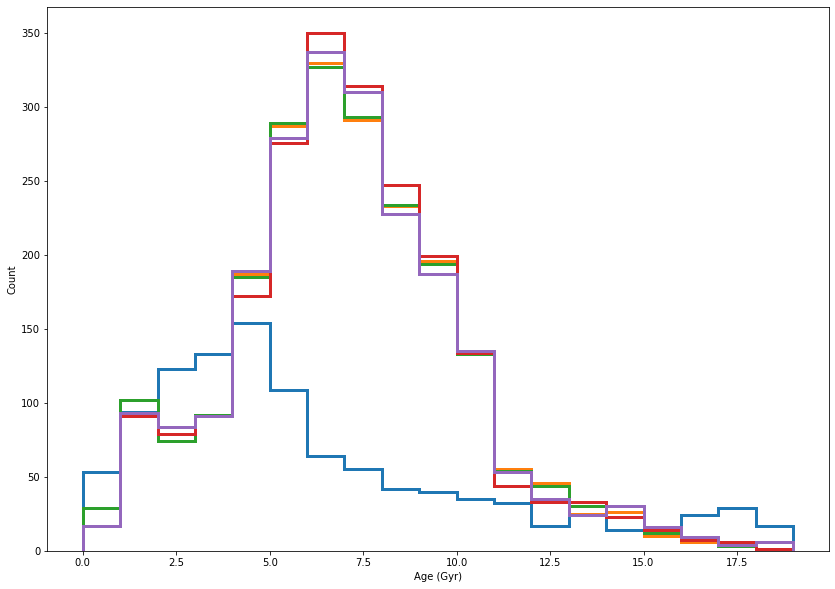

In [46]:
fin = np.where(np.isfinite(10**parages/10**9)==True)
plt.figure(figsize=[14,10])
plt.hist(10**parages[fin]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**mad_parages[fin]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**ll_parages[fin]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**max_resid_parages[fin]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**current_parages[fin]/10**9,range(0,20),histtype='step',lw=3.0)

plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Count')

(array([ 8., 59., 53., 33., 34., 21., 34., 33., 36., 19., 26.,  7., 14.,
        15., 17., 11.,  5.,  2.,  3.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [<matplotlib.patches.Polygon at 0x7fe94a6c5760>])

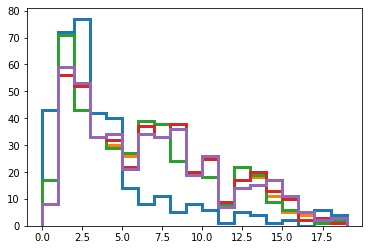

In [43]:
# plt.hist(10**parages[over_phot_idx]/10**9,range(0,20))

# fin = np.where(np.isfinite(10**parages/10**9)==True)
plt.hist(10**parages[over_phot_idx]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**mad_parages[over_phot_idx]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**ll_parages[over_phot_idx]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**max_resid_parages[over_phot_idx]/10**9,range(0,20),histtype='step',lw=3.0)
plt.hist(10**current_parages[over_phot_idx]/10**9,range(0,20),histtype='step',lw=3.0)

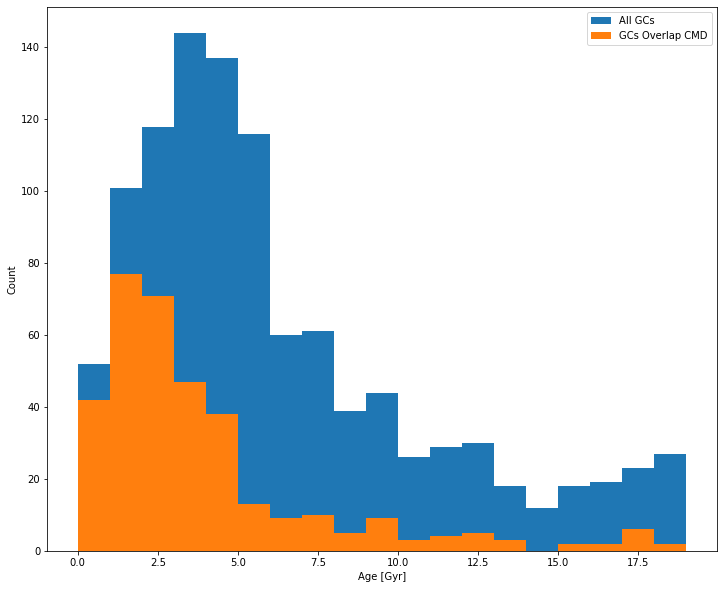

In [40]:
fin = np.where(np.isfinite(10**parages/10**9)==True)

plt.figure(figsize=[12,10])
plt.hist(10**parages[fin]/10**9,range(0,20),label='All GCs')
plt.hist(10**parages[over_phot_idx]/10**9,range(0,20),label='GCs Overlap CMD')

plt.legend()

plt.xlabel(r'Age [Gyr]')
plt.ylabel(r'Count')

plt.savefig('calculated_ages.pdf',bbox_inches='tight')
plt.show()

In [41]:
#################
### Residuals ###
#################

### Predicted vs Theoretical
plt.figure(figsize=[12,10])
plt.scatter(pred_cur_age,parsec['logAge'],c=parsec['logg'],cmap='nipy_spectral')
plt.plot([8,10.25],[8,10.25],c='k')
plt.colorbar()

plt.title(r'Predicted Current Age Parsec Age vs Theoretical Parsec Age')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Age')
plt.savefig('parsec_pred_v_theo.pdf',bbox_inches='tight')
plt.show()

### Offset
plt.figure(figsize=[12,10])
plt.scatter(pred_cur_age,parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset')
plt.xlabel(r'Predicted Age')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_pred.pdf',bbox_inches='tight')
plt.show()

### Offset vs Temp
plt.figure(figsize=[12,10])
plt.scatter(10**parsec['logTe'],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs Temp; Color as logg')
plt.xlabel(r'Temp')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_temp.pdf',bbox_inches='tight')
plt.show()

### Offset vs K
plt.figure(figsize=[12,10])
plt.scatter(parsec['Ksmag'],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs K; Color as logg')
plt.xlabel(r'K')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_K.pdf',bbox_inches='tight')
plt.show()

### Offset vs [Fe/H]
plt.figure(figsize=[12,10])
plt.scatter(parsec['MH'],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs [FE/H]; Color as logg')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_feh.pdf',bbox_inches='tight')
plt.show()

### Offset vs Logg
plt.figure(figsize=[12,10])
plt.scatter(parsec['logg'],parsec['logAge']-pred_cur_age,c=parsec['MH'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs logg; Color as [FE/H]')
plt.xlabel(r'logg')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.savefig('parsec_offset_v_logg.pdf',bbox_inches='tight')
plt.show()

### Offset vs q0
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[0],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q0; Color as logg')
plt.xlabel(r'q0')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.show()

### Offset vs q1
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[1],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q1; Color as logg')
plt.xlabel(r'q1')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.show()

### Offset vs q2
plt.figure(figsize=[12,10])
plt.scatter(new_par.T[2],parsec['logAge']-pred_cur_age,c=parsec['logg'],cmap='nipy_spectral')
plt.colorbar()

plt.axhline(0,c='k')

plt.title(r'Age Offset vs q2; Color as logg')
plt.xlabel(r'q2')
plt.ylabel(r'Theoretical Parsec Age - Predicted Current Age Parsec Age')
plt.show()

'NGC3201'

In [42]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages'

-8.650836041770283

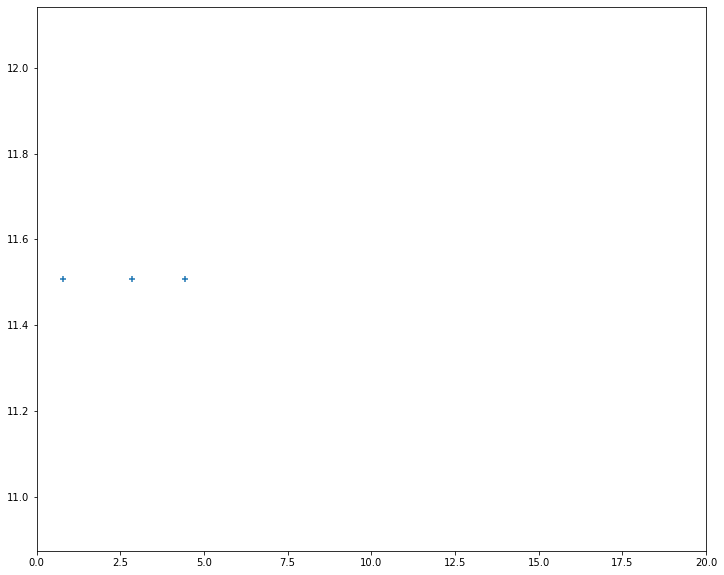

In [43]:
pal5 = np.where(gcs['Cluster']=='Pal5')
n3201 = np.where(gcs['Cluster']==supp2['Cluster'][10])

plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[pal5]/10**9,11.508*np.ones(len(np.squeeze(pal5))),marker='+',cmap='nipy_spectral')

# plt.ylim(-10,10)
plt.xlim(0,20)
# plt.colorbar()
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
# plt.ylim(10**7,10**11)
# plt.xlim(10**7,10**13)

np.median(10**np.asarray(parages)[pal5]/10**9)-11.508

In [44]:
supp2['Age']

0     13.00
1     12.00
2     12.50
3     12.75
4     12.50
      ...  
64    13.00
65    11.50
66    11.50
67     8.00
68    13.50
Name: Age, Length: 69, dtype: float64

Text(0, 0.5, 'Log(g)')

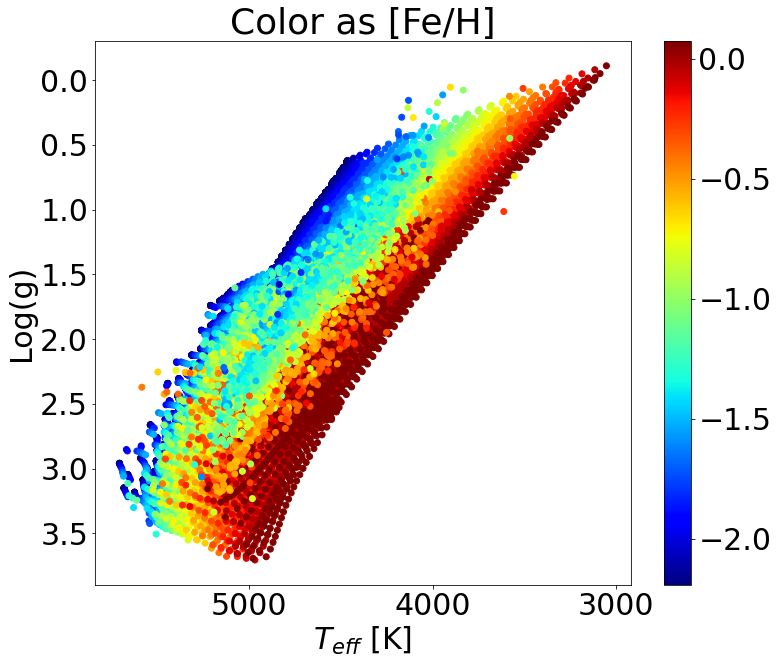

In [45]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=[12,10])

cln = np.where((gcs['LOGG']>0.0)&(gcs['FE_H']>-100.))

plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],cmap='jet',zorder=1)

# plt.errorbar(gcs['TEFF'][cln],gcs['LOGG'][cln],xerr=gcs['TEFF_ERR'][cln],yerr=gcs['LOGG_ERR'][cln],c='lightgrey',
#              zorder=1,ls='none')
plt.scatter(gcs['TEFF'][cln],gcs['LOGG'][cln],c=afunc.sal(gcs['M_H'][cln],gcs['ALPHA_M'][cln]),cmap='jet',
            zorder=2,vmin=min(parsec['MH']),
            vmax=max(parsec['MH']))
plt.colorbar()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'$T_{eff}$ [K]')
plt.ylabel(r'Log(g)')

Text(0, 0.5, 'Log(g)')

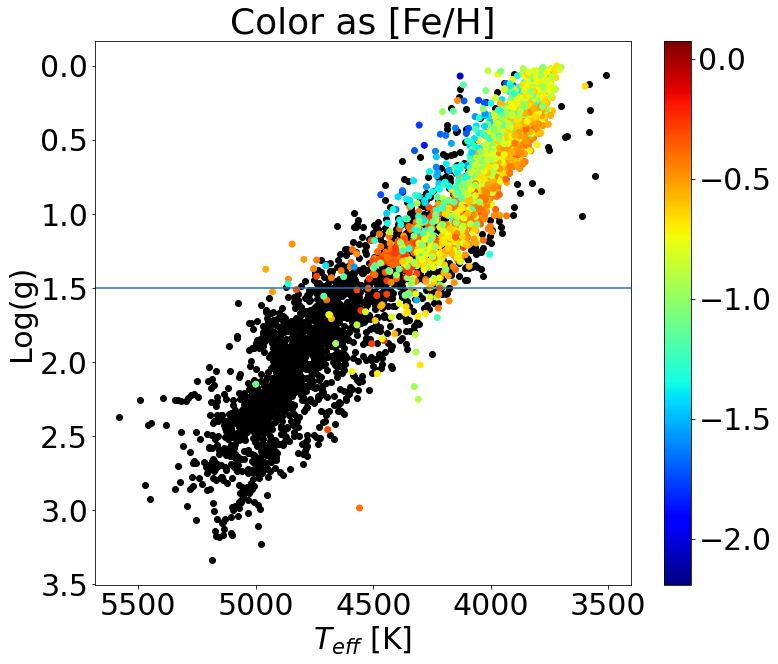

In [46]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=[12,10])

# afunc.sal(gcs['M_H'][cln],gcs['ALPHA_M'][cln])
plt.scatter(gcs['TEFF'][cln],gcs['LOGG'][cln],c='k',cmap='jet',
            zorder=1,vmin=min(parsec['MH']),
            vmax=max(parsec['MH']))
plt.scatter(lmc['TEFF'],lmc['LOGG'],c=afunc.sal(lmc['M_H'],lmc['ALPHA_M']),cmap='jet',
            zorder=2,vmin=min(parsec['MH']),
            vmax=max(parsec['MH']))
plt.colorbar()

plt.axhline(1.5)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'$T_{eff}$ [K]')
plt.ylabel(r'Log(g)')

In [47]:
gcs.columns

ColDefs(
    name = 'APSTAR_ID'; format = '60A'
    name = 'TARGET_ID'; format = '50A'
    name = 'ASPCAP_ID'; format = '62A'
    name = 'FILE'; format = '39A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '8A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '19A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '192A'
    name = 'SURVEY'; format = '35A'
    name = 'PROGRAMNAME'; format = '18A'
    na

(array([0.09313121, 0.08940596, 0.02869448, 0.00382593, 0.00261774,
        0.00110751, 0.00040273, 0.00050341, 0.00020136, 0.00010068]),
 array([ 1.2047 ,  5.75034, 10.29598, 14.84162, 19.38726, 23.9329 ,
        28.47854, 33.02418, 37.56982, 42.11546, 46.6611 ]),
 <BarContainer object of 10 artists>)

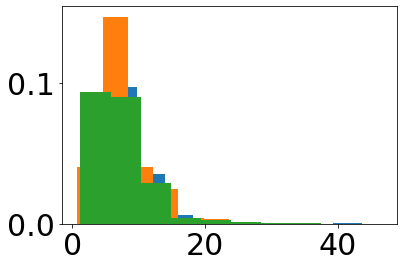

In [48]:
plt.hist(gcs['D1_Med'],density=True)
plt.hist(gcs['r_sph'],density=True)
plt.hist(gcs['distmed'],density=True)

In [49]:
supp2.columns

Index(['Cluster', 'Dist', 'Dist_Sigma', 'Av', 'Av_Sigma', '[Fe/H]', 'Age'], dtype='object')

In [50]:
clus = np.where(gcs['Cluster']=='NGC6723')
suppclus = int(np.squeeze(np.where(supp2['Cluster']=='NGC6723')))

dist1851 = 10**(0.2*(supp2['Dist'][suppclus]+5-supp2['Av'][suppclus]))

In [51]:
dist1851

8649.67918775693

In [52]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

for i in tqdm_notebook(range(len(np.squeeze(gcs[clus]))),desc='Done?'):
    # temperature
    teff = gcs[clus]['TEFF'][i]
    teff_err = gcs[clus]['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs[clus]['RA'][i]
    dec = gcs[clus]['DEC'][i]
    ks = gcs[clus]['K'][i]
    ks_err = gcs[clus]['K_ERR'][i]
    ak = gcs[clus]['AK_TARG'][i]
    
    distmod = supp2['Dist'][suppclus]
    distmod_err = supp2['Dist_Sigma'][suppclus]
    av = supp2['Av'][suppclus]
    av_err = supp2['Av_Sigma'][suppclus]
    
    # abundances
    mh = gcs[clus]['M_H'][i]
    mh_err = gcs[clus]['M_H_ERR'][i]
    cfe = gcs[clus]['C_FE'][i]
    cfe_err = gcs[clus]['C_FE_ERR'][i]
    nfe = gcs[clus]['N_FE'][i]
    nfe_err = gcs[clus]['N_FE_ERR'][i]
    feh = gcs[clus]['FE_H'][i]
    feh_err = gcs[clus]['FE_H_ERR'][i]
    am = gcs[clus]['ALPHA_M'][i]
    am_err = gcs[clus]['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs[clus]['LOGG'][i]
    lgg_err = gcs[clus]['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        dist_new = 10**((add_noise(distmod,distmod_err)+5-add_noise(av,av_err))/5.)/10**3 #-add_noise(av,av_err)
#         dist_new = 10**((distmod+5-av)/5.)/10**3
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
#         am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

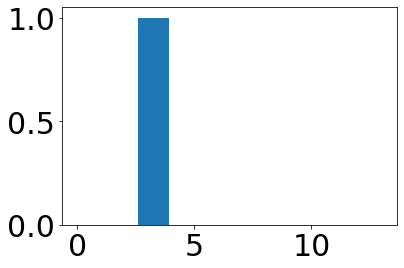

In [53]:
plt.hist(10**np.asarray(parages)/10**9,range=(0,13))

In [54]:
supp2['Age'][10]

12.0

In [55]:

np.mean(10**np.asarray(parages)[np.where(10**np.asarray(parages)/10**9<14.)]/10**9)

3.2597122083136174

In [56]:
afunc.mad(10**np.asarray(parages)[np.where(10**np.asarray(parages)/10**9<14.)]/10**9)

0.0

In [57]:
5.794721518612621+3.4167512610225965-12.0 #NGC3201

-2.7885272203647826

In [58]:
5.740127624555221+2.378486064446957-11.433 #NGC1851

-3.314386310997822

In [59]:
6.296134482535379+2.2527358021623614-11.092 #NGC2808

-2.5431297153022605

In [60]:
np.mean([-2.7885272203647826,-3.314386310997822,-2.5431297153022605])

-2.882014415554955